In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import warnings


from torchsummary import summary
from pthflops import count_ops
warnings.filterwarnings('ignore')


torch.cuda.empty_cache()

D:\Programs\Python3.10.7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!unzip /content/Natural-Faces.zip                                         # CODE TO MOVE IMAGES FROM ONE FOLDER TO ANOTHER
# import os, random
# import shutil

# m=10

# src_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/train/contempt/"
# dst_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/test/contempt/"

# file_list = os.listdir(src_dir)

# for i in range(m):
    
#     a = random.choice(file_list)
#         #file_list.remove(a)
#     shutil.move(src_dir + a, dst_dir+ a)

In [3]:
def load_data(train_path, test_path, batch_size,input_size,mn,sd,shuffle_test=False):
    
    ######## Write your code here ########
    transform_dict={"src":transforms.Compose([transforms.Resize(size=input_size),transforms.RandomHorizontalFlip(),transforms.RandomAdjustSharpness(sharpness_factor=0.3),
            transforms.RandomVerticalFlip(),transforms.ToTensor(),transforms.Normalize(mean=mn,std=sd)])}

    train=datasets.ImageFolder(root=train_path,transform=transform_dict["src"],)
    
    
    labelslist=train.class_to_idx
    dataset_size = len(train)
    
    train_size = int(round(0.85 * dataset_size))
    val_size = int(round(0.15 * dataset_size))
    

    train_dataset,val_dataset = torch.utils.data.random_split(train,[train_size,val_size])
    test_dataset=datasets.ImageFolder(root=test_path,transform=transform_dict["src"])
    
    

    print('Size Of Train Dataset',len(train_dataset))
    print('Size Of Test Dataset',len(test_dataset))
    print('Size Of Validation Dataset',len(val_dataset))
   

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    shuffle=False, drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
 
      
    return data_loader_train, data_loader_test,data_loader_val,labelslist

In [4]:
# model1=models.resnet50(weights=True)               # FINDING NO OF LAYERS IN A MODEL AND DISPLAYING THEM
# ct=0
# for child in model1.children():
#     ct+=1
#     print('--------------')
#     print(child)
# print(ct)


model_vgg_frozen = models.vgg16(weights=True)         # CREATING MODELS FREEZING ALL THE LAYERS EXCEPT THE FC LAYER
ct = 0
for child in model_vgg_frozen.children():
    ct += 1
    if ct < 3:
        for param in child.parameters():
            param.requires_grad = False
            
model_resnet_frozen = models.resnet50(weights=True)
ct = 0
for child in model_resnet_frozen.children():
    ct += 1
    if ct < 10:
        for param in child.parameters():
            param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\raqui/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [00:10<00:00, 50.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\raqui/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 49.1MB/s]


In [5]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  

# Natural Faces: 
	
# M: [0.5236, 0.5236, 0.5236]
# SD:[0.2351, 0.2351, 0.2351]


# Tiny:

# M: [0.5422, 0.4674, 0.4349]
# SD: [0.2665, 0.2500, 0.2517]

# Masked-Fer2013:

# M: [0.4652, 0.5198, 0.5736]
# SD: [0.2354, 0.2363, 0.2666]


In [6]:
def img_show(train_loader,lablist):

    
    
    images,labels=next(iter(train_loader))
    
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    print(lablist)
    
    figure = plt.figure(figsize=(5, 5))
    cols, rows = 3, 3             #Displays 9 images in a 3*3 grid
    for i in range(1, cols * rows + 1):

        img = images[i].squeeze()
        img_label = labels[i]
        
        label=(list(lablist.keys())[list(lablist.values()).index(img_label)])
        
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    



In [7]:
def grp_show(x,y,label,col,x_label,y_label,title,path):
    
    for i in range(0,len(y)):
      plt.plot(x, y[i], col[i], label=label[i])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    plt.savefig(f'{path}{title}.jpg')
    
    plt.show()
 


In [8]:
def train_model(num_epochs,train_loader,val_loader):
    model.train()
    Train_steps = len(train_loader)
    Val_steps=len(val_loader)
    print('Total Steps',Train_steps)
    t1 = time.time()

    acclist_train=[]
    acclist_val=[]
    losslist_train=[]
    losslist_val=[]
    epc=[]
    cons_epchs=0
    loss_criteria=0.0001
    last_loss=np.Inf
    verbose=10
    

    for epoch in range(num_epochs):
        
        # exp_lr_scheduler.step()
        # print('Epoch:', epoch+1,'LR:', exp_lr_scheduler.get_lr())
        
        
        correct=0
        total=0
        loss_train=0
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)#Feedforward
            loss = criterion(outputs, labels)
            optimizer.zero_grad()#Gradient
            loss.backward()#Weights update
            optimizer.step()

            total+= labels.size(0) 

            _,predicted = torch.max(outputs.data, 1) #1 so that all the data is on the same line

            correct+= (predicted == labels).sum().item()
            loss_train+=loss.item()
            if (i + 1)  == Train_steps:

                  correct_v = 0                                                 #Validation Loop
                  total_v = 0
                  loss_v=0
                  for dataVal in val_loader:
                      images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                      outputs_v = model(images_v)
                      loss=criterion(outputs_v,labels_v)
                      _, predicted_v = torch.max(outputs_v.data, 1)
                      correct_v += (predicted_v == labels_v).sum().item()
                      total_v += labels_v.size(0)
                      loss_v+=loss.item()
              
                  print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.4f},'
                      .format(epoch + 1, num_epochs, loss_train/Train_steps, loss_v/Val_steps, (correct / total) * 100, (correct_v / total_v) * 100))
                  
                  acclist_train.append((correct / total) * 100)
                  acclist_val.append((correct_v / total_v) * 100)
                  losslist_train.append(loss_train/Train_steps)
                  losslist_val.append(loss_v/Val_steps)
                  epc.append(epoch+1)

                  
                  
                  current_loss=loss_v/Val_steps

                  if (last_loss-current_loss)<=loss_criteria:
                      cons_epchs += 1
                      last_loss = current_loss
                      
                      if cons_epchs >= verbose:
                        print('Loss Did Not Improve by more than 0.0001 for 10 epochs..Stopping')
                        print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
                        return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

                  else:
                    cons_epchs = 0

                  

 
               
    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

In [9]:
from torch.cuda import device
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model,test_loader):
    model.eval() 

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        
        
        print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
        ConfusionMatrixDisplay(conf_mat).plot()
        plt.show()

Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


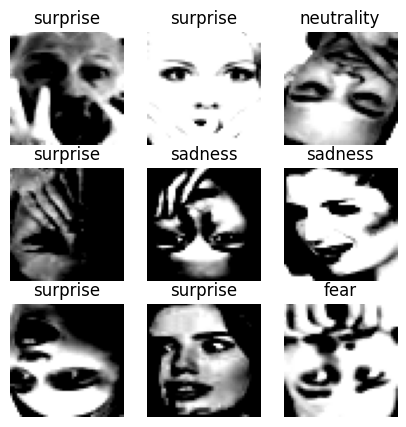

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 24, 24, 24]          648
|    └─BatchNorm2d: 2-2                  [-1, 24, 24, 24]          48
|    └─ReLU: 2-3                         [-1, 24, 24, 24]          --
├─MaxPool2d: 1-2                         [-1, 24, 12, 12]          --
├─Sequential: 1-3                        [-1, 48, 6, 6]            --
|    └─InvertedResidual: 2-4             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-1              [-1, 24, 6, 6]            888
|    |    └─Sequential: 3-2              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-5             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-3              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-6             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-4    

Epoch [34/150], Training Loss: 1.8518, Validation Loss: 1.9404, Training Accuracy: 29.88%, Validation Accuracy: 27.3247,
Epoch [35/150], Training Loss: 1.8594, Validation Loss: 1.9095, Training Accuracy: 28.49%, Validation Accuracy: 25.0358,
Epoch [36/150], Training Loss: 1.8441, Validation Loss: 1.9122, Training Accuracy: 29.98%, Validation Accuracy: 25.6080,
Epoch [37/150], Training Loss: 1.8526, Validation Loss: 1.9005, Training Accuracy: 28.90%, Validation Accuracy: 27.6109,
Epoch [38/150], Training Loss: 1.8411, Validation Loss: 1.9223, Training Accuracy: 28.82%, Validation Accuracy: 25.0358,
Epoch [39/150], Training Loss: 1.8246, Validation Loss: 1.9087, Training Accuracy: 30.51%, Validation Accuracy: 26.4664,
Epoch [40/150], Training Loss: 1.8182, Validation Loss: 1.9233, Training Accuracy: 31.62%, Validation Accuracy: 26.8956,
Epoch [41/150], Training Loss: 1.8180, Validation Loss: 1.8751, Training Accuracy: 31.40%, Validation Accuracy: 28.3262,
Epoch [42/150], Training Loss: 1

Epoch [102/150], Training Loss: 1.5256, Validation Loss: 1.9496, Training Accuracy: 44.13%, Validation Accuracy: 30.7582,
Epoch [103/150], Training Loss: 1.5330, Validation Loss: 1.9562, Training Accuracy: 44.46%, Validation Accuracy: 27.6109,
Epoch [104/150], Training Loss: 1.5150, Validation Loss: 1.9624, Training Accuracy: 45.26%, Validation Accuracy: 29.7568,
Epoch [105/150], Training Loss: 1.5029, Validation Loss: 2.0022, Training Accuracy: 44.53%, Validation Accuracy: 25.6080,
Epoch [106/150], Training Loss: 1.5114, Validation Loss: 2.0285, Training Accuracy: 44.23%, Validation Accuracy: 27.7539,
Epoch [107/150], Training Loss: 1.4983, Validation Loss: 1.9981, Training Accuracy: 45.64%, Validation Accuracy: 29.7568,
Epoch [108/150], Training Loss: 1.4865, Validation Loss: 1.9854, Training Accuracy: 45.01%, Validation Accuracy: 30.1860,
Epoch [109/150], Training Loss: 1.4901, Validation Loss: 1.9565, Training Accuracy: 45.44%, Validation Accuracy: 29.8999,
Epoch [110/150], Trainin

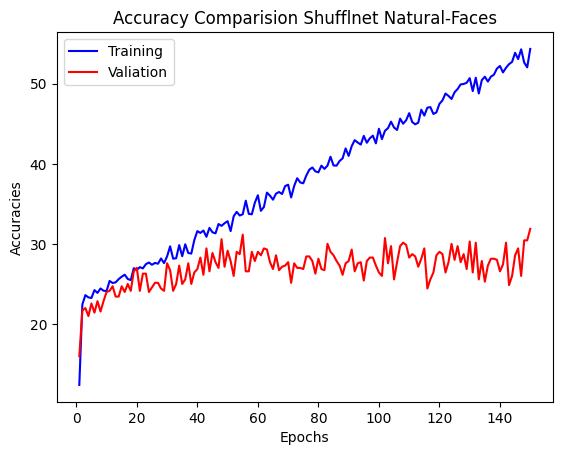

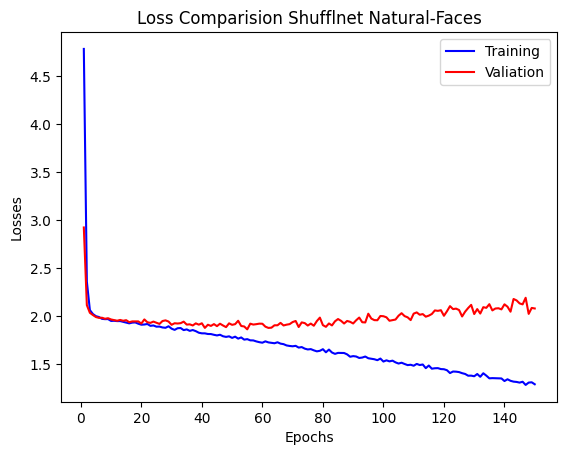

Test Accuracy of the model on the 900 test images: 28.111111111111107 %


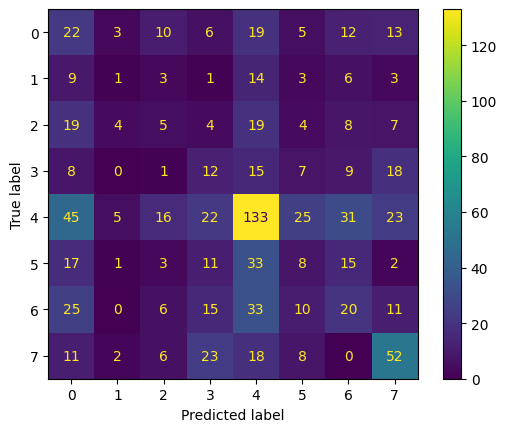

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


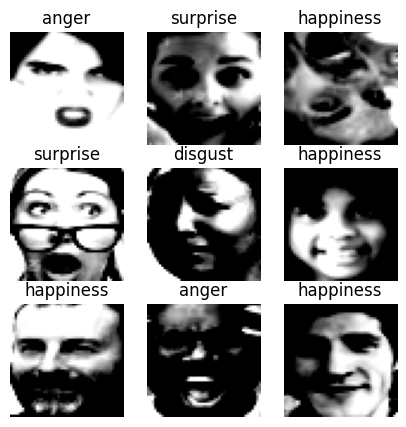

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 576, 2, 2]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 16, 24, 24]          432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 24, 24]          32
|    |    └─Hardswish: 3-3                         [-1, 16, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 12, 12]          --
|    |    └─Sequential: 3-4                        [-1, 16, 12, 12]          744
|    └─InvertedResidual: 2-3                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-5                        [-1, 24, 6, 6]            3,864
|    └─InvertedResidual: 2-4                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-6                        [-1, 24, 6, 6

Epoch [37/150], Training Loss: 1.2076, Validation Loss: 2.2828, Training Accuracy: 56.18%, Validation Accuracy: 29.1845,
Epoch [38/150], Training Loss: 1.1692, Validation Loss: 2.3543, Training Accuracy: 58.27%, Validation Accuracy: 28.4692,
Epoch [39/150], Training Loss: 1.1559, Validation Loss: 2.4071, Training Accuracy: 58.83%, Validation Accuracy: 29.8999,
Epoch [40/150], Training Loss: 1.1448, Validation Loss: 2.3316, Training Accuracy: 58.88%, Validation Accuracy: 28.4692,
Epoch [41/150], Training Loss: 1.1293, Validation Loss: 2.3550, Training Accuracy: 59.16%, Validation Accuracy: 28.7554,
Epoch [42/150], Training Loss: 1.1136, Validation Loss: 2.5257, Training Accuracy: 60.72%, Validation Accuracy: 26.7525,
Epoch [43/150], Training Loss: 1.0866, Validation Loss: 2.4483, Training Accuracy: 60.62%, Validation Accuracy: 28.6123,
Epoch [44/150], Training Loss: 1.0545, Validation Loss: 2.6116, Training Accuracy: 61.66%, Validation Accuracy: 28.8984,
Epoch [45/150], Training Loss: 1

Epoch [105/150], Training Loss: 0.3754, Validation Loss: 4.0619, Training Accuracy: 87.35%, Validation Accuracy: 26.8956,
Epoch [106/150], Training Loss: 0.4094, Validation Loss: 3.9915, Training Accuracy: 85.78%, Validation Accuracy: 27.4678,
Epoch [107/150], Training Loss: 0.3959, Validation Loss: 3.9726, Training Accuracy: 86.28%, Validation Accuracy: 30.6152,
Epoch [108/150], Training Loss: 0.3722, Validation Loss: 3.8547, Training Accuracy: 87.04%, Validation Accuracy: 28.6123,
Epoch [109/150], Training Loss: 0.3610, Validation Loss: 4.0087, Training Accuracy: 87.75%, Validation Accuracy: 26.6094,
Epoch [110/150], Training Loss: 0.3320, Validation Loss: 4.1943, Training Accuracy: 88.28%, Validation Accuracy: 28.4692,
Epoch [111/150], Training Loss: 0.3685, Validation Loss: 4.1910, Training Accuracy: 87.37%, Validation Accuracy: 28.3262,
Epoch [112/150], Training Loss: 0.3290, Validation Loss: 4.0483, Training Accuracy: 88.86%, Validation Accuracy: 28.4692,
Epoch [113/150], Trainin

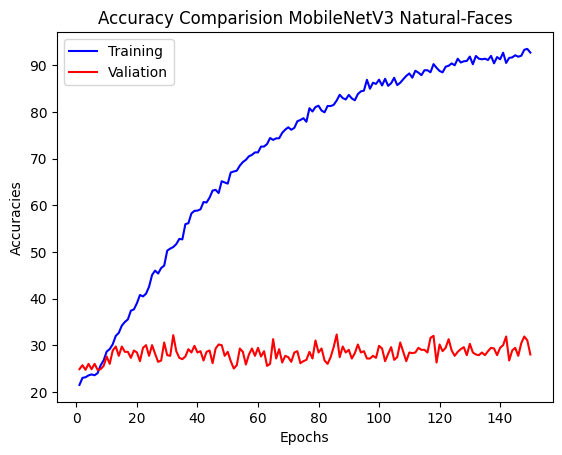

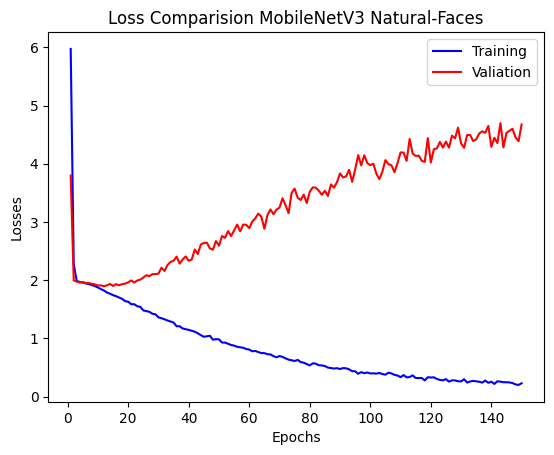

Test Accuracy of the model on the 900 test images: 29.444444444444446 %


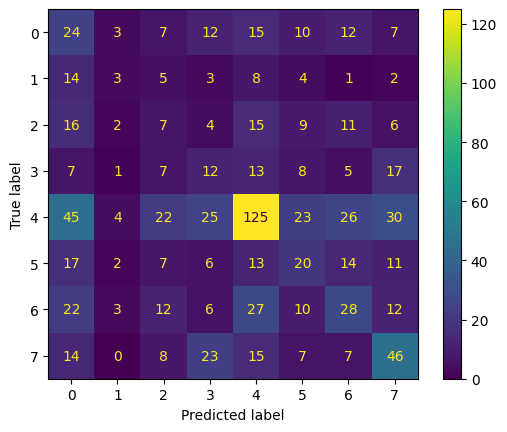

Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


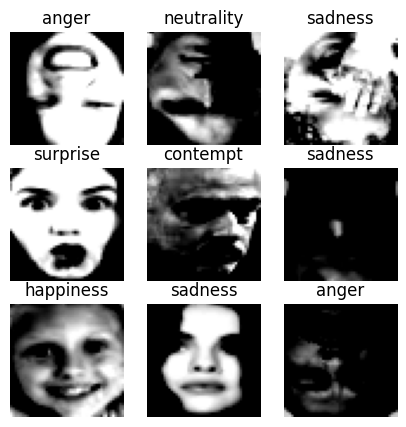

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 2, 2]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 32, 24, 24]          864
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 24, 24]          64
|    |    └─ReLU6: 3-3                             [-1, 32, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 24, 24]          --
|    |    └─Sequential: 3-4                        [-1, 16, 24, 24]          896
|    └─InvertedResidual: 2-3                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-5                        [-1, 24, 12, 12]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-6                        [-1, 24, 12, 

Epoch [31/150], Training Loss: 1.6378, Validation Loss: 1.9700, Training Accuracy: 39.10%, Validation Accuracy: 27.1817,
Epoch [32/150], Training Loss: 1.6290, Validation Loss: 1.9692, Training Accuracy: 38.92%, Validation Accuracy: 25.8941,
Epoch [33/150], Training Loss: 1.6189, Validation Loss: 2.0037, Training Accuracy: 39.53%, Validation Accuracy: 27.3247,
Epoch [34/150], Training Loss: 1.5948, Validation Loss: 1.9950, Training Accuracy: 41.05%, Validation Accuracy: 28.0401,
Epoch [35/150], Training Loss: 1.5916, Validation Loss: 1.9547, Training Accuracy: 41.65%, Validation Accuracy: 27.8970,
Epoch [36/150], Training Loss: 1.5919, Validation Loss: 1.9902, Training Accuracy: 41.63%, Validation Accuracy: 29.1845,
Epoch [37/150], Training Loss: 1.5652, Validation Loss: 2.0138, Training Accuracy: 42.49%, Validation Accuracy: 25.7511,
Epoch [38/150], Training Loss: 1.5553, Validation Loss: 1.9942, Training Accuracy: 42.28%, Validation Accuracy: 29.3276,
Epoch [39/150], Training Loss: 1

Epoch [99/150], Training Loss: 0.7366, Validation Loss: 2.8381, Training Accuracy: 74.31%, Validation Accuracy: 27.6109,
Epoch [100/150], Training Loss: 0.7263, Validation Loss: 2.8494, Training Accuracy: 74.72%, Validation Accuracy: 30.9013,
Epoch [101/150], Training Loss: 0.7176, Validation Loss: 2.8272, Training Accuracy: 75.07%, Validation Accuracy: 28.8984,
Epoch [102/150], Training Loss: 0.7175, Validation Loss: 2.8807, Training Accuracy: 75.35%, Validation Accuracy: 27.7539,
Epoch [103/150], Training Loss: 0.7128, Validation Loss: 2.8577, Training Accuracy: 75.55%, Validation Accuracy: 29.8999,
Epoch [104/150], Training Loss: 0.6947, Validation Loss: 3.0228, Training Accuracy: 75.52%, Validation Accuracy: 27.3247,
Epoch [105/150], Training Loss: 0.7058, Validation Loss: 2.9123, Training Accuracy: 74.89%, Validation Accuracy: 27.8970,
Epoch [106/150], Training Loss: 0.7262, Validation Loss: 2.8854, Training Accuracy: 74.97%, Validation Accuracy: 27.3247,
Epoch [107/150], Training

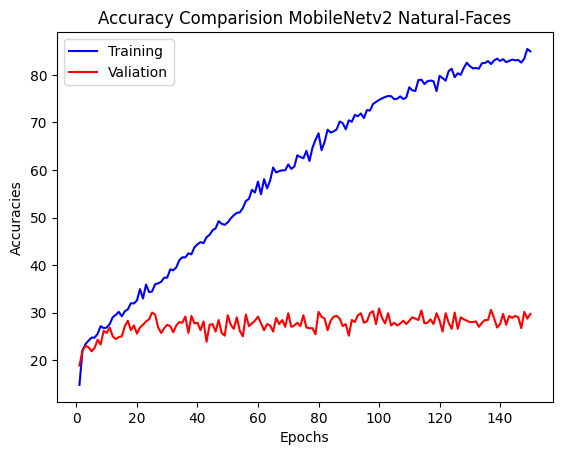

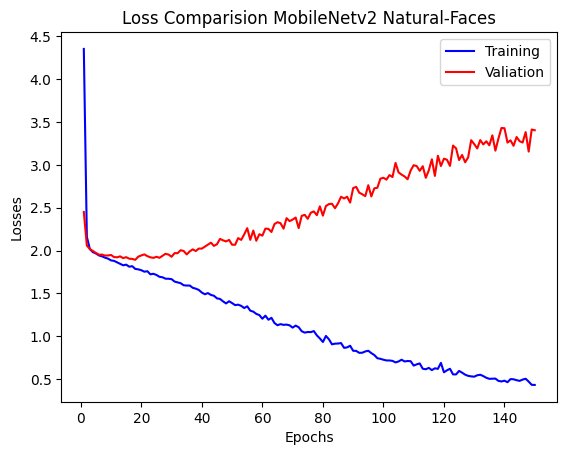

Test Accuracy of the model on the 900 test images: 30.666666666666664 %


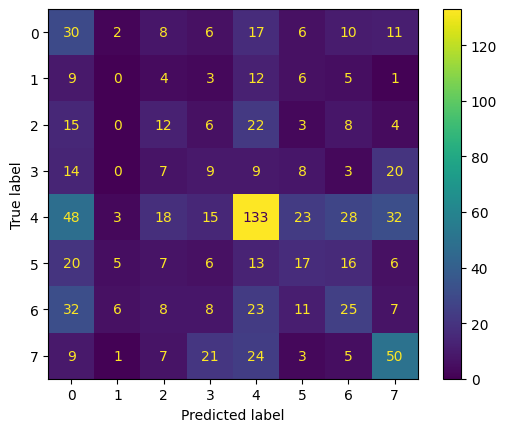

Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


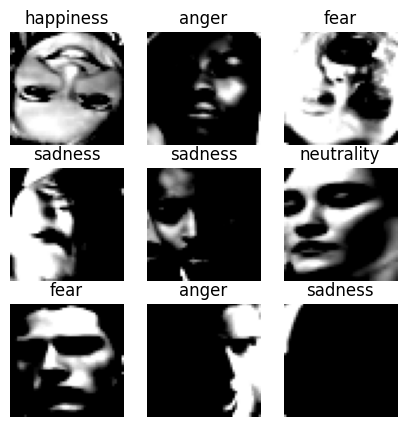

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1280, 2, 2]          --
|    └─Conv2d: 2-1                       [-1, 16, 24, 24]          432
|    └─BatchNorm2d: 2-2                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-3                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 16, 24, 24]          144
|    └─BatchNorm2d: 2-5                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-6                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-7                       [-1, 8, 24, 24]           128
|    └─BatchNorm2d: 2-8                  [-1, 8, 24, 24]           16
|    └─Sequential: 2-9                   [-1, 16, 12, 12]          --
|    |    └─_InvertedResidual: 3-1       [-1, 16, 12, 12]          920
|    |    └─_InvertedResidual: 3-2       [-1, 16, 12, 12]          2,192
|    |    └─_InvertedResidual: 3

Epoch [41/150], Training Loss: 1.8262, Validation Loss: 2.0305, Training Accuracy: 30.71%, Validation Accuracy: 25.0358,
Epoch [42/150], Training Loss: 1.8256, Validation Loss: 2.0004, Training Accuracy: 30.31%, Validation Accuracy: 23.6052,
Epoch [43/150], Training Loss: 1.8124, Validation Loss: 1.9834, Training Accuracy: 31.42%, Validation Accuracy: 23.6052,
Epoch [44/150], Training Loss: 1.7830, Validation Loss: 2.0307, Training Accuracy: 31.57%, Validation Accuracy: 24.8927,
Epoch [45/150], Training Loss: 1.8102, Validation Loss: 2.0444, Training Accuracy: 31.47%, Validation Accuracy: 25.1788,
Epoch [46/150], Training Loss: 1.8101, Validation Loss: 2.0247, Training Accuracy: 31.02%, Validation Accuracy: 24.1774,
Epoch [47/150], Training Loss: 1.8005, Validation Loss: 2.0415, Training Accuracy: 31.60%, Validation Accuracy: 20.8870,
Epoch [48/150], Training Loss: 1.7725, Validation Loss: 2.0340, Training Accuracy: 33.09%, Validation Accuracy: 22.7468,
Epoch [49/150], Training Loss: 1

Epoch [109/150], Training Loss: 1.3851, Validation Loss: 2.2763, Training Accuracy: 49.86%, Validation Accuracy: 24.6066,
Epoch [110/150], Training Loss: 1.3434, Validation Loss: 2.3573, Training Accuracy: 50.64%, Validation Accuracy: 25.4649,
Epoch [111/150], Training Loss: 1.3757, Validation Loss: 2.3471, Training Accuracy: 50.21%, Validation Accuracy: 22.6037,
Epoch [112/150], Training Loss: 1.3659, Validation Loss: 2.2937, Training Accuracy: 50.11%, Validation Accuracy: 23.0329,
Epoch [113/150], Training Loss: 1.3566, Validation Loss: 2.2512, Training Accuracy: 50.80%, Validation Accuracy: 26.0372,
Epoch [114/150], Training Loss: 1.3438, Validation Loss: 2.3798, Training Accuracy: 51.65%, Validation Accuracy: 23.0329,
Epoch [115/150], Training Loss: 1.3569, Validation Loss: 2.4503, Training Accuracy: 50.01%, Validation Accuracy: 22.4607,
Epoch [116/150], Training Loss: 1.3258, Validation Loss: 2.4536, Training Accuracy: 51.93%, Validation Accuracy: 20.6009,
Epoch [117/150], Trainin

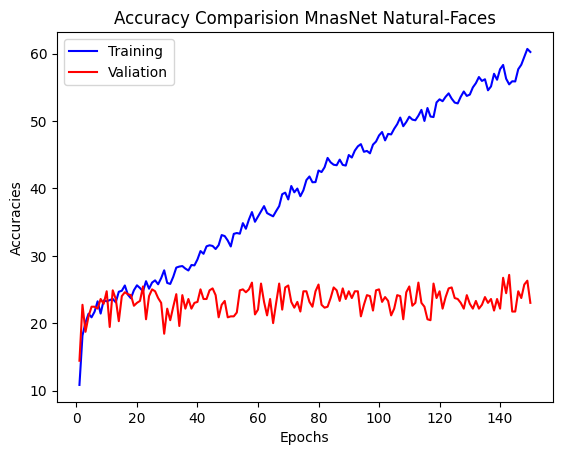

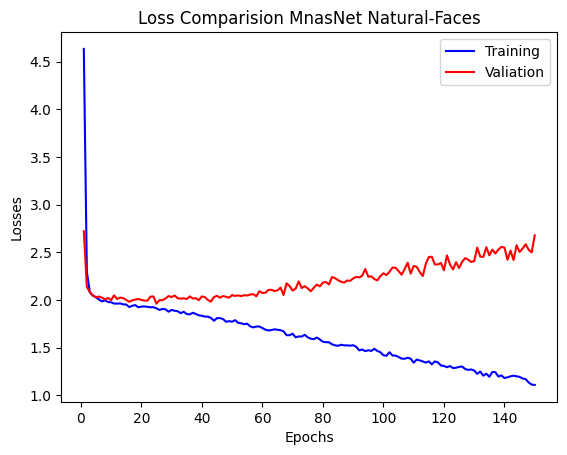

Test Accuracy of the model on the 900 test images: 33.33333333333333 %


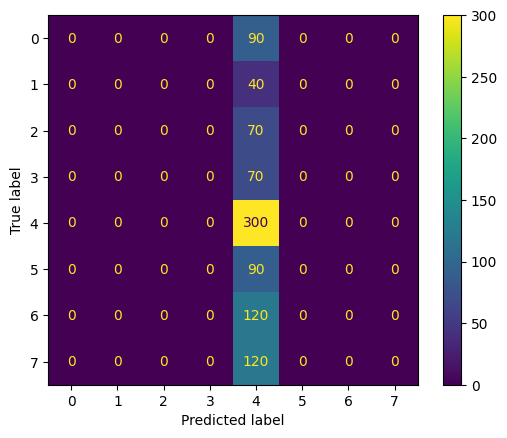

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


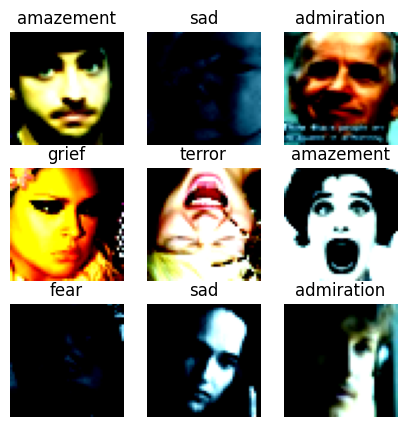

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 24, 24, 24]          648
|    └─BatchNorm2d: 2-2                  [-1, 24, 24, 24]          48
|    └─ReLU: 2-3                         [-1, 24, 24, 24]          --
├─MaxPool2d: 1-2                         [-1, 24, 12, 12]          --
├─Sequential: 1-3                        [-1, 48, 6, 6]            --
|    └─InvertedResidual: 2-4             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-1              [-1, 24, 6, 6]            888
|    |    └─Sequential: 3-2              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-5             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-3              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-6             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-4    

Epoch [34/150], Training Loss: 1.7103, Validation Loss: 1.8508, Training Accuracy: 35.03%, Validation Accuracy: 29.3538,
Epoch [35/150], Training Loss: 1.7011, Validation Loss: 1.8341, Training Accuracy: 35.27%, Validation Accuracy: 30.2359,
Epoch [36/150], Training Loss: 1.6951, Validation Loss: 1.8541, Training Accuracy: 35.49%, Validation Accuracy: 29.2923,
Epoch [37/150], Training Loss: 1.6926, Validation Loss: 1.8312, Training Accuracy: 35.40%, Validation Accuracy: 30.8308,
Epoch [38/150], Training Loss: 1.6865, Validation Loss: 1.8564, Training Accuracy: 35.87%, Validation Accuracy: 29.3538,
Epoch [39/150], Training Loss: 1.6715, Validation Loss: 1.8486, Training Accuracy: 36.63%, Validation Accuracy: 30.3385,
Epoch [40/150], Training Loss: 1.6686, Validation Loss: 1.8530, Training Accuracy: 36.74%, Validation Accuracy: 29.8256,
Epoch [41/150], Training Loss: 1.6608, Validation Loss: 1.8331, Training Accuracy: 36.35%, Validation Accuracy: 30.2769,
Epoch [42/150], Training Loss: 1

Epoch [102/150], Training Loss: 1.4078, Validation Loss: 1.8705, Training Accuracy: 47.44%, Validation Accuracy: 32.2256,
Epoch [103/150], Training Loss: 1.3996, Validation Loss: 1.8886, Training Accuracy: 47.89%, Validation Accuracy: 31.2205,
Epoch [104/150], Training Loss: 1.4090, Validation Loss: 1.8647, Training Accuracy: 47.50%, Validation Accuracy: 32.5949,
Epoch [105/150], Training Loss: 1.3893, Validation Loss: 1.8866, Training Accuracy: 48.08%, Validation Accuracy: 32.5128,
Epoch [106/150], Training Loss: 1.3888, Validation Loss: 1.8741, Training Accuracy: 48.35%, Validation Accuracy: 32.3897,
Epoch [107/150], Training Loss: 1.3937, Validation Loss: 1.8834, Training Accuracy: 47.98%, Validation Accuracy: 31.5487,
Epoch [108/150], Training Loss: 1.3871, Validation Loss: 1.9001, Training Accuracy: 48.38%, Validation Accuracy: 31.1590,
Epoch [109/150], Training Loss: 1.3827, Validation Loss: 1.8971, Training Accuracy: 48.43%, Validation Accuracy: 30.9538,
Epoch [110/150], Trainin

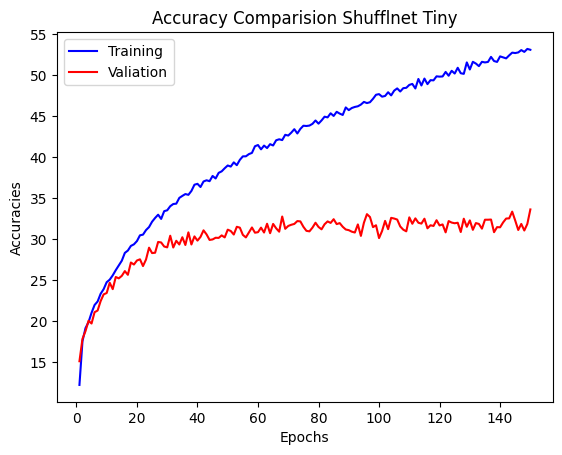

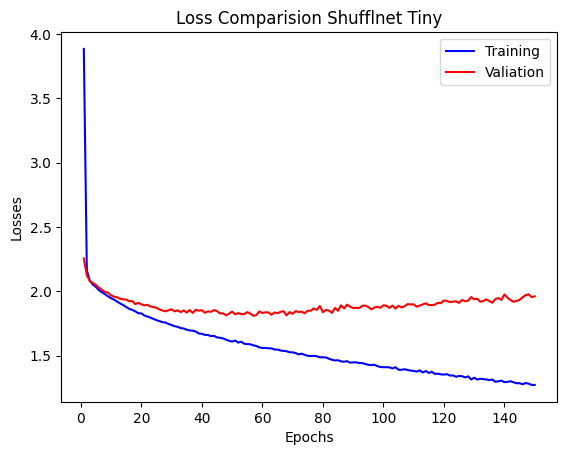

Test Accuracy of the model on the 9837 test images: 36.68801463860933 %


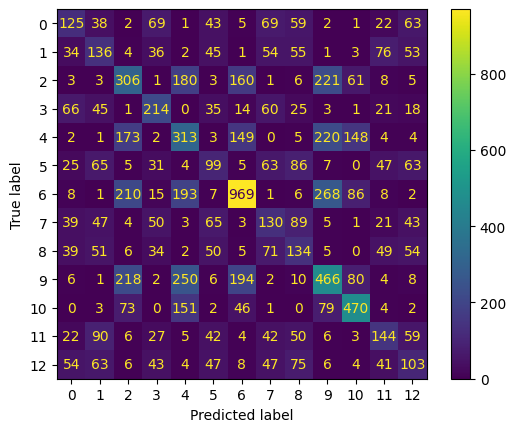

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


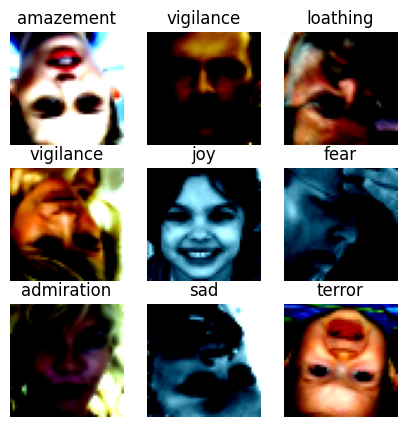

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 576, 2, 2]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 16, 24, 24]          432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 24, 24]          32
|    |    └─Hardswish: 3-3                         [-1, 16, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 12, 12]          --
|    |    └─Sequential: 3-4                        [-1, 16, 12, 12]          744
|    └─InvertedResidual: 2-3                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-5                        [-1, 24, 6, 6]            3,864
|    └─InvertedResidual: 2-4                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-6                        [-1, 24, 6, 6

Epoch [37/150], Training Loss: 1.4546, Validation Loss: 1.9017, Training Accuracy: 46.08%, Validation Accuracy: 31.2000,
Epoch [38/150], Training Loss: 1.4491, Validation Loss: 1.8787, Training Accuracy: 46.02%, Validation Accuracy: 32.5949,
Epoch [39/150], Training Loss: 1.4378, Validation Loss: 1.8722, Training Accuracy: 46.75%, Validation Accuracy: 31.7333,
Epoch [40/150], Training Loss: 1.4240, Validation Loss: 1.8916, Training Accuracy: 47.08%, Validation Accuracy: 31.9385,
Epoch [41/150], Training Loss: 1.4199, Validation Loss: 1.9056, Training Accuracy: 47.57%, Validation Accuracy: 31.7538,
Epoch [42/150], Training Loss: 1.4046, Validation Loss: 1.9062, Training Accuracy: 48.25%, Validation Accuracy: 32.2667,
Epoch [43/150], Training Loss: 1.3951, Validation Loss: 1.9110, Training Accuracy: 48.38%, Validation Accuracy: 31.4667,
Epoch [44/150], Training Loss: 1.3781, Validation Loss: 1.9369, Training Accuracy: 48.92%, Validation Accuracy: 31.4667,
Epoch [45/150], Training Loss: 1

Epoch [105/150], Training Loss: 0.8652, Validation Loss: 2.5593, Training Accuracy: 69.15%, Validation Accuracy: 31.1179,
Epoch [106/150], Training Loss: 0.8491, Validation Loss: 2.5260, Training Accuracy: 69.56%, Validation Accuracy: 31.8359,
Epoch [107/150], Training Loss: 0.8462, Validation Loss: 2.5521, Training Accuracy: 69.60%, Validation Accuracy: 30.7897,
Epoch [108/150], Training Loss: 0.8398, Validation Loss: 2.5527, Training Accuracy: 70.05%, Validation Accuracy: 31.8359,
Epoch [109/150], Training Loss: 0.8343, Validation Loss: 2.6032, Training Accuracy: 69.99%, Validation Accuracy: 30.8513,
Epoch [110/150], Training Loss: 0.8168, Validation Loss: 2.6318, Training Accuracy: 70.77%, Validation Accuracy: 30.9128,
Epoch [111/150], Training Loss: 0.8132, Validation Loss: 2.5628, Training Accuracy: 70.92%, Validation Accuracy: 32.5538,
Epoch [112/150], Training Loss: 0.8091, Validation Loss: 2.6511, Training Accuracy: 70.97%, Validation Accuracy: 30.7692,
Epoch [113/150], Trainin

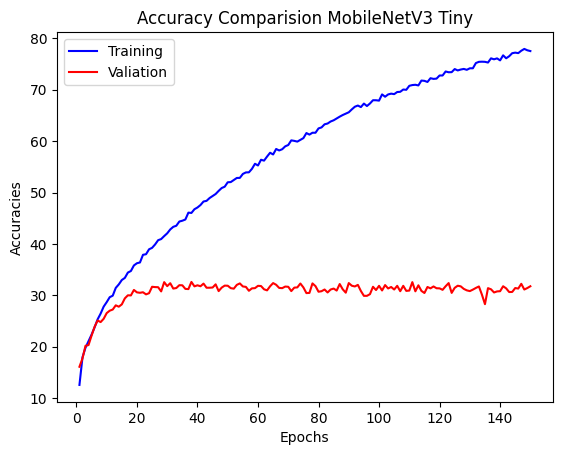

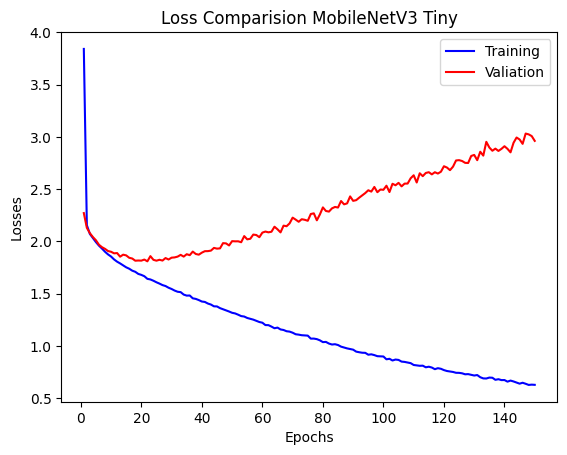

Test Accuracy of the model on the 9837 test images: 33.414658940733965 %


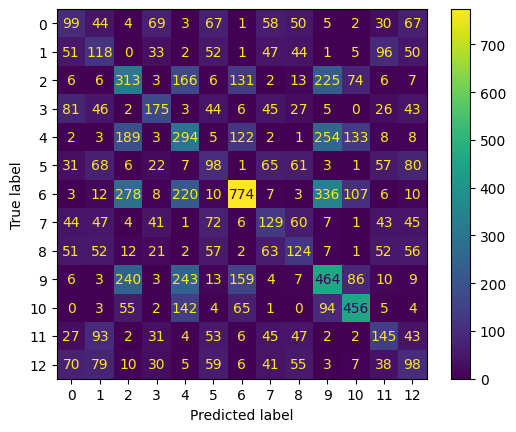

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


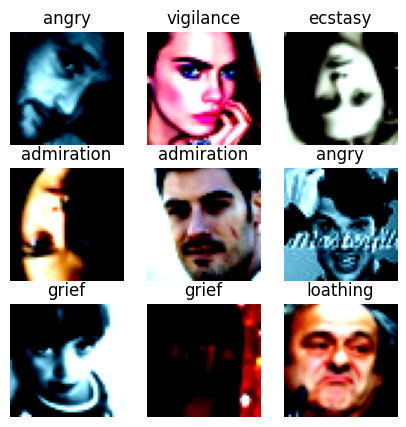

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 2, 2]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 32, 24, 24]          864
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 24, 24]          64
|    |    └─ReLU6: 3-3                             [-1, 32, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 24, 24]          --
|    |    └─Sequential: 3-4                        [-1, 16, 24, 24]          896
|    └─InvertedResidual: 2-3                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-5                        [-1, 24, 12, 12]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-6                        [-1, 24, 12, 

Epoch [31/150], Training Loss: 1.4721, Validation Loss: 1.7523, Training Accuracy: 44.57%, Validation Accuracy: 35.4051,
Epoch [32/150], Training Loss: 1.4618, Validation Loss: 1.7734, Training Accuracy: 45.35%, Validation Accuracy: 34.0718,
Epoch [33/150], Training Loss: 1.4413, Validation Loss: 1.7778, Training Accuracy: 45.86%, Validation Accuracy: 34.5641,
Epoch [34/150], Training Loss: 1.4298, Validation Loss: 1.7743, Training Accuracy: 46.71%, Validation Accuracy: 34.6462,
Epoch [35/150], Training Loss: 1.4147, Validation Loss: 1.7660, Training Accuracy: 47.04%, Validation Accuracy: 35.7538,
Epoch [36/150], Training Loss: 1.4017, Validation Loss: 1.8095, Training Accuracy: 47.32%, Validation Accuracy: 33.6615,
Epoch [37/150], Training Loss: 1.3860, Validation Loss: 1.8412, Training Accuracy: 48.00%, Validation Accuracy: 34.5846,
Epoch [38/150], Training Loss: 1.3766, Validation Loss: 1.7675, Training Accuracy: 48.64%, Validation Accuracy: 35.1179,
Epoch [39/150], Training Loss: 1

Epoch [99/150], Training Loss: 0.7551, Validation Loss: 2.4741, Training Accuracy: 73.05%, Validation Accuracy: 35.3846,
Epoch [100/150], Training Loss: 0.7343, Validation Loss: 2.4692, Training Accuracy: 73.73%, Validation Accuracy: 34.9538,
Epoch [101/150], Training Loss: 0.7304, Validation Loss: 2.5071, Training Accuracy: 73.89%, Validation Accuracy: 34.5641,
Epoch [102/150], Training Loss: 0.7370, Validation Loss: 2.4966, Training Accuracy: 73.52%, Validation Accuracy: 35.1590,
Epoch [103/150], Training Loss: 0.7160, Validation Loss: 2.5050, Training Accuracy: 74.37%, Validation Accuracy: 34.9128,
Epoch [104/150], Training Loss: 0.7110, Validation Loss: 2.5016, Training Accuracy: 74.75%, Validation Accuracy: 36.4103,
Epoch [105/150], Training Loss: 0.7203, Validation Loss: 2.5553, Training Accuracy: 74.02%, Validation Accuracy: 34.5846,
Epoch [106/150], Training Loss: 0.7018, Validation Loss: 2.5327, Training Accuracy: 74.94%, Validation Accuracy: 34.9949,
Epoch [107/150], Training

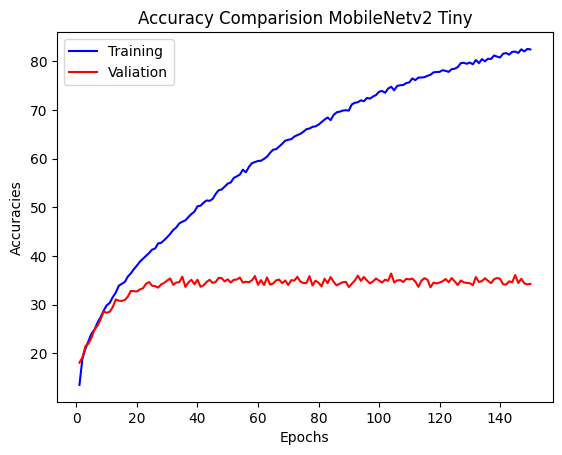

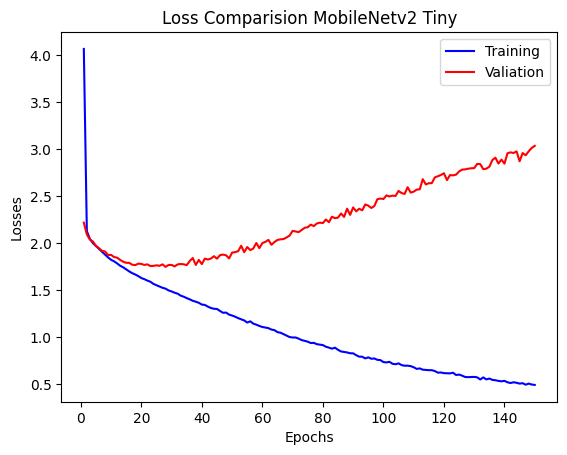

Test Accuracy of the model on the 9837 test images: 39.1481142624784 %


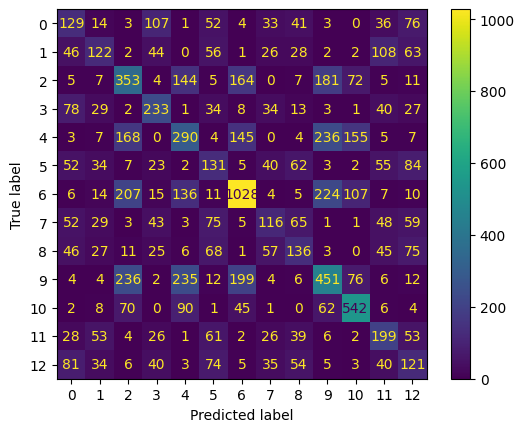

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


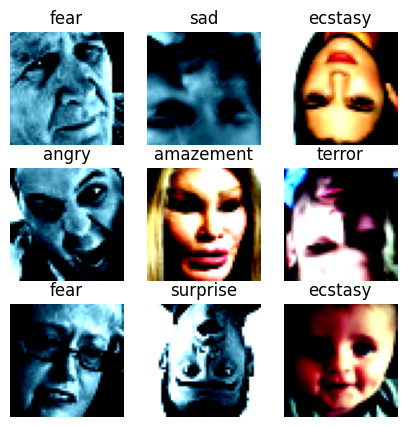

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1280, 2, 2]          --
|    └─Conv2d: 2-1                       [-1, 16, 24, 24]          432
|    └─BatchNorm2d: 2-2                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-3                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 16, 24, 24]          144
|    └─BatchNorm2d: 2-5                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-6                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-7                       [-1, 8, 24, 24]           128
|    └─BatchNorm2d: 2-8                  [-1, 8, 24, 24]           16
|    └─Sequential: 2-9                   [-1, 16, 12, 12]          --
|    |    └─_InvertedResidual: 3-1       [-1, 16, 12, 12]          920
|    |    └─_InvertedResidual: 3-2       [-1, 16, 12, 12]          2,192
|    |    └─_InvertedResidual: 3

Epoch [41/150], Training Loss: 1.6022, Validation Loss: 1.7759, Training Accuracy: 38.68%, Validation Accuracy: 33.4359,
Epoch [42/150], Training Loss: 1.5954, Validation Loss: 1.7887, Training Accuracy: 39.35%, Validation Accuracy: 32.1846,
Epoch [43/150], Training Loss: 1.5870, Validation Loss: 1.7842, Training Accuracy: 39.86%, Validation Accuracy: 32.4513,
Epoch [44/150], Training Loss: 1.5773, Validation Loss: 1.7755, Training Accuracy: 40.20%, Validation Accuracy: 33.2718,
Epoch [45/150], Training Loss: 1.5729, Validation Loss: 1.7954, Training Accuracy: 40.04%, Validation Accuracy: 33.3538,
Epoch [46/150], Training Loss: 1.5733, Validation Loss: 1.7769, Training Accuracy: 40.16%, Validation Accuracy: 32.8821,
Epoch [47/150], Training Loss: 1.5663, Validation Loss: 1.8005, Training Accuracy: 40.71%, Validation Accuracy: 32.0410,
Epoch [48/150], Training Loss: 1.5537, Validation Loss: 1.7878, Training Accuracy: 40.79%, Validation Accuracy: 32.7795,
Epoch [49/150], Training Loss: 1

Epoch [109/150], Training Loss: 1.2467, Validation Loss: 1.9314, Training Accuracy: 53.63%, Validation Accuracy: 33.5385,
Epoch [110/150], Training Loss: 1.2247, Validation Loss: 1.9379, Training Accuracy: 54.58%, Validation Accuracy: 33.4154,
Epoch [111/150], Training Loss: 1.2391, Validation Loss: 1.9499, Training Accuracy: 53.83%, Validation Accuracy: 33.2718,
Epoch [112/150], Training Loss: 1.2318, Validation Loss: 1.9421, Training Accuracy: 54.35%, Validation Accuracy: 34.2359,
Epoch [113/150], Training Loss: 1.2267, Validation Loss: 1.9463, Training Accuracy: 54.44%, Validation Accuracy: 34.1333,
Epoch [114/150], Training Loss: 1.2147, Validation Loss: 1.9701, Training Accuracy: 54.90%, Validation Accuracy: 33.6205,
Epoch [115/150], Training Loss: 1.2185, Validation Loss: 1.9717, Training Accuracy: 55.10%, Validation Accuracy: 32.9026,
Epoch [116/150], Training Loss: 1.2043, Validation Loss: 2.0210, Training Accuracy: 55.24%, Validation Accuracy: 32.4103,
Epoch [117/150], Trainin

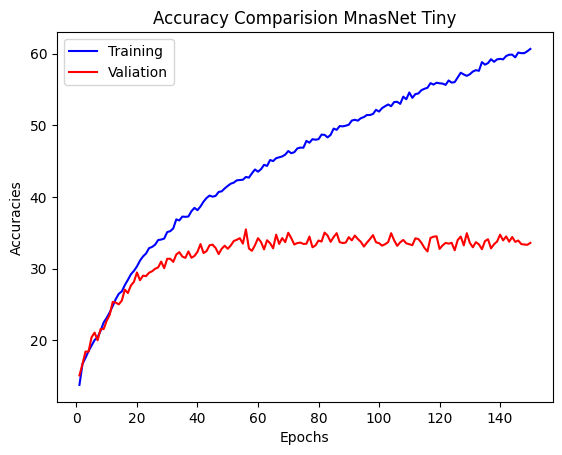

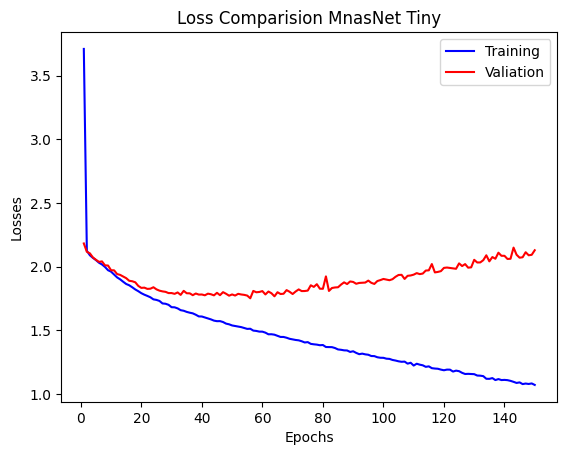

Test Accuracy of the model on the 9837 test images: 36.68801463860933 %


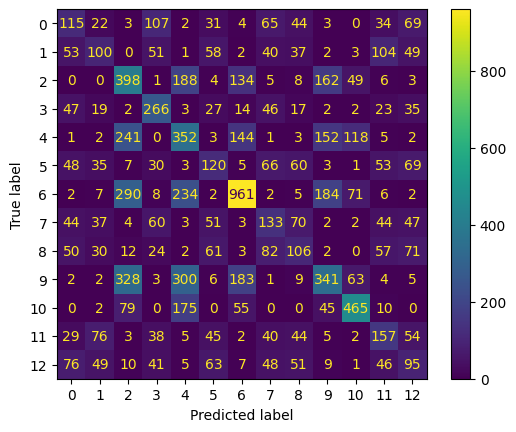

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


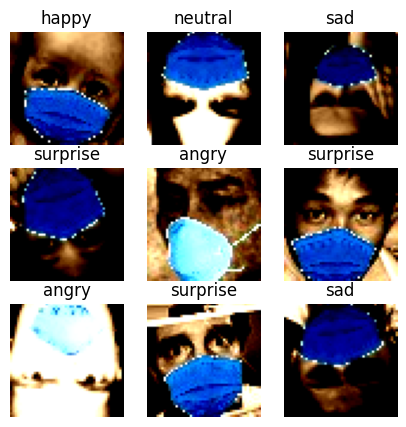

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 24, 24, 24]          648
|    └─BatchNorm2d: 2-2                  [-1, 24, 24, 24]          48
|    └─ReLU: 2-3                         [-1, 24, 24, 24]          --
├─MaxPool2d: 1-2                         [-1, 24, 12, 12]          --
├─Sequential: 1-3                        [-1, 48, 6, 6]            --
|    └─InvertedResidual: 2-4             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-1              [-1, 24, 6, 6]            888
|    |    └─Sequential: 3-2              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-5             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-3              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-6             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-4    

Epoch [34/150], Training Loss: 0.8423, Validation Loss: 1.0529, Training Accuracy: 63.70%, Validation Accuracy: 54.7582,
Epoch [35/150], Training Loss: 0.8302, Validation Loss: 1.0204, Training Accuracy: 64.41%, Validation Accuracy: 56.0062,
Epoch [36/150], Training Loss: 0.8286, Validation Loss: 1.0242, Training Accuracy: 64.68%, Validation Accuracy: 56.4743,
Epoch [37/150], Training Loss: 0.8242, Validation Loss: 1.0230, Training Accuracy: 65.10%, Validation Accuracy: 56.9423,
Epoch [38/150], Training Loss: 0.8163, Validation Loss: 1.0295, Training Accuracy: 65.21%, Validation Accuracy: 55.4602,
Epoch [39/150], Training Loss: 0.8139, Validation Loss: 1.0293, Training Accuracy: 65.47%, Validation Accuracy: 55.3822,
Epoch [40/150], Training Loss: 0.7980, Validation Loss: 1.0327, Training Accuracy: 67.08%, Validation Accuracy: 54.8362,
Epoch [41/150], Training Loss: 0.7975, Validation Loss: 1.0449, Training Accuracy: 66.39%, Validation Accuracy: 54.3682,
Epoch [42/150], Training Loss: 0

Epoch [102/150], Training Loss: 0.5638, Validation Loss: 1.1611, Training Accuracy: 77.72%, Validation Accuracy: 54.9142,
Epoch [103/150], Training Loss: 0.5608, Validation Loss: 1.1612, Training Accuracy: 77.47%, Validation Accuracy: 56.3573,
Epoch [104/150], Training Loss: 0.5475, Validation Loss: 1.1805, Training Accuracy: 78.44%, Validation Accuracy: 55.8112,
Epoch [105/150], Training Loss: 0.5752, Validation Loss: 1.1845, Training Accuracy: 77.86%, Validation Accuracy: 55.9282,
Epoch [106/150], Training Loss: 0.5464, Validation Loss: 1.1996, Training Accuracy: 78.38%, Validation Accuracy: 55.6552,
Epoch [107/150], Training Loss: 0.5392, Validation Loss: 1.2211, Training Accuracy: 78.51%, Validation Accuracy: 53.7051,
Epoch [108/150], Training Loss: 0.5530, Validation Loss: 1.1675, Training Accuracy: 77.97%, Validation Accuracy: 55.4992,
Epoch [109/150], Training Loss: 0.5382, Validation Loss: 1.1762, Training Accuracy: 78.74%, Validation Accuracy: 57.1763,
Epoch [110/150], Trainin

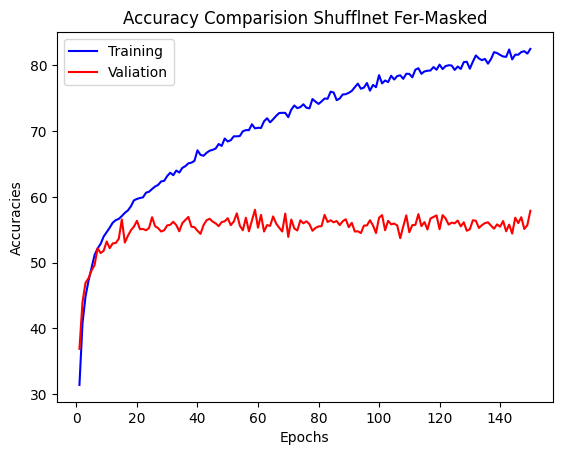

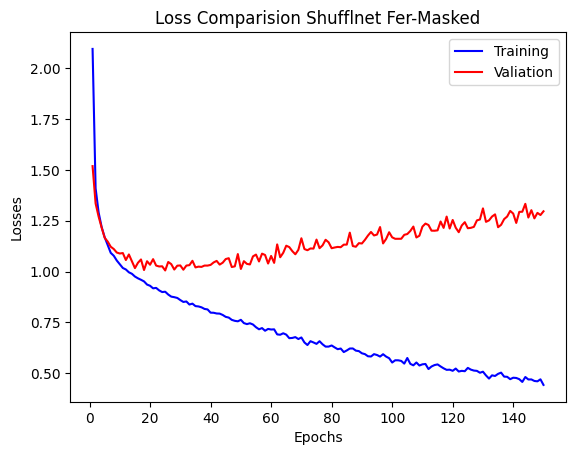

Test Accuracy of the model on the 4250 test images: 41.2235294117647 %


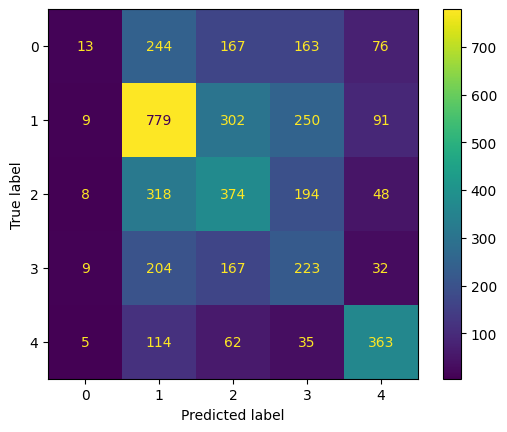

Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


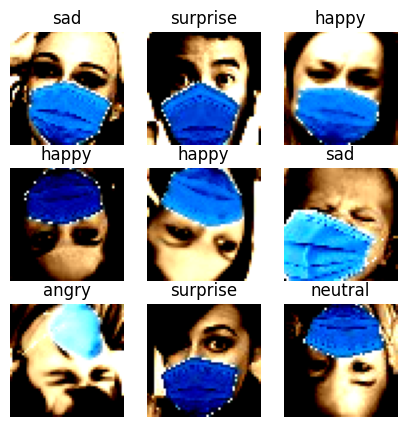

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 576, 2, 2]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 16, 24, 24]          432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 24, 24]          32
|    |    └─Hardswish: 3-3                         [-1, 16, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 12, 12]          --
|    |    └─Sequential: 3-4                        [-1, 16, 12, 12]          744
|    └─InvertedResidual: 2-3                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-5                        [-1, 24, 6, 6]            3,864
|    └─InvertedResidual: 2-4                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-6                        [-1, 24, 6, 6

Epoch [37/150], Training Loss: 0.5264, Validation Loss: 1.3509, Training Accuracy: 79.42%, Validation Accuracy: 55.5772,
Epoch [38/150], Training Loss: 0.5148, Validation Loss: 1.3805, Training Accuracy: 79.68%, Validation Accuracy: 53.5101,
Epoch [39/150], Training Loss: 0.5139, Validation Loss: 1.3464, Training Accuracy: 80.10%, Validation Accuracy: 53.7051,
Epoch [40/150], Training Loss: 0.4979, Validation Loss: 1.3709, Training Accuracy: 80.88%, Validation Accuracy: 53.5101,
Epoch [41/150], Training Loss: 0.4913, Validation Loss: 1.4446, Training Accuracy: 81.59%, Validation Accuracy: 54.3682,
Epoch [42/150], Training Loss: 0.4848, Validation Loss: 1.4391, Training Accuracy: 81.26%, Validation Accuracy: 53.9782,
Epoch [43/150], Training Loss: 0.4795, Validation Loss: 1.4339, Training Accuracy: 81.76%, Validation Accuracy: 54.1342,
Epoch [44/150], Training Loss: 0.4786, Validation Loss: 1.5236, Training Accuracy: 81.83%, Validation Accuracy: 54.1342,
Epoch [45/150], Training Loss: 0

Epoch [105/150], Training Loss: 0.2040, Validation Loss: 2.0619, Training Accuracy: 92.53%, Validation Accuracy: 55.3042,
Epoch [106/150], Training Loss: 0.2058, Validation Loss: 2.0694, Training Accuracy: 92.68%, Validation Accuracy: 55.2652,
Epoch [107/150], Training Loss: 0.1924, Validation Loss: 2.0548, Training Accuracy: 93.06%, Validation Accuracy: 54.6412,
Epoch [108/150], Training Loss: 0.2011, Validation Loss: 2.0571, Training Accuracy: 92.95%, Validation Accuracy: 55.3822,
Epoch [109/150], Training Loss: 0.1991, Validation Loss: 2.0758, Training Accuracy: 93.03%, Validation Accuracy: 52.9641,
Epoch [110/150], Training Loss: 0.1967, Validation Loss: 2.1045, Training Accuracy: 92.86%, Validation Accuracy: 54.7582,
Epoch [111/150], Training Loss: 0.2034, Validation Loss: 2.1412, Training Accuracy: 92.69%, Validation Accuracy: 54.7972,
Epoch [112/150], Training Loss: 0.1945, Validation Loss: 2.1012, Training Accuracy: 93.32%, Validation Accuracy: 53.7441,
Epoch [113/150], Trainin

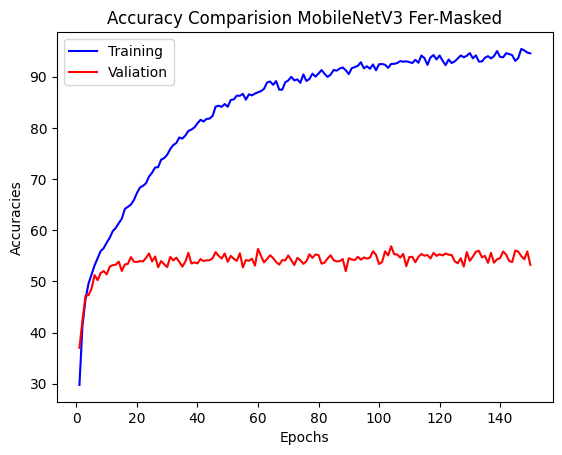

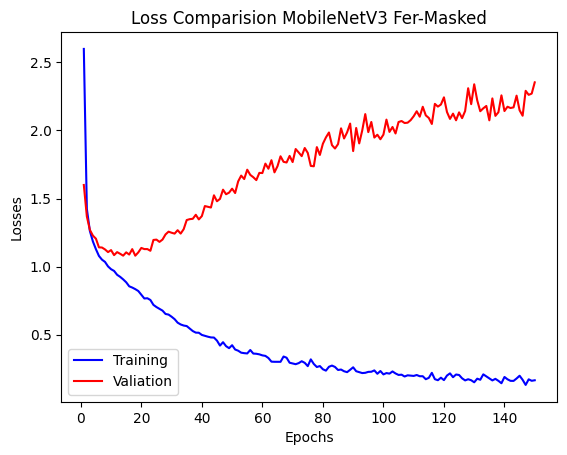

Test Accuracy of the model on the 4250 test images: 40.51764705882353 %


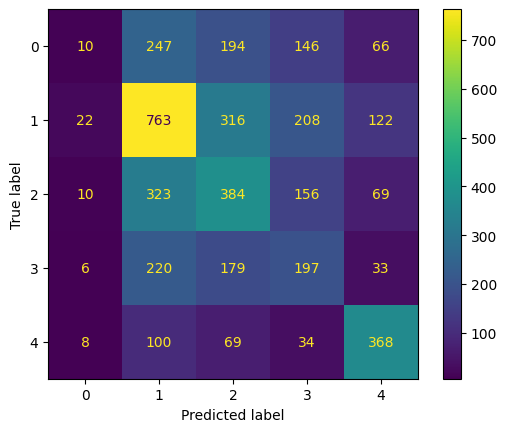

Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


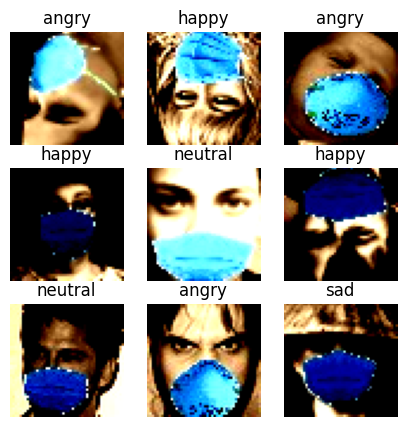

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 2, 2]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 32, 24, 24]          864
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 24, 24]          64
|    |    └─ReLU6: 3-3                             [-1, 32, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 24, 24]          --
|    |    └─Sequential: 3-4                        [-1, 16, 24, 24]          896
|    └─InvertedResidual: 2-3                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-5                        [-1, 24, 12, 12]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-6                        [-1, 24, 12, 

Epoch [31/150], Training Loss: 0.6143, Validation Loss: 1.2618, Training Accuracy: 75.40%, Validation Accuracy: 54.6022,
Epoch [32/150], Training Loss: 0.6016, Validation Loss: 1.1888, Training Accuracy: 76.26%, Validation Accuracy: 55.4212,
Epoch [33/150], Training Loss: 0.6013, Validation Loss: 1.2386, Training Accuracy: 75.95%, Validation Accuracy: 56.1232,
Epoch [34/150], Training Loss: 0.5518, Validation Loss: 1.2336, Training Accuracy: 78.01%, Validation Accuracy: 56.3183,
Epoch [35/150], Training Loss: 0.5449, Validation Loss: 1.2750, Training Accuracy: 78.86%, Validation Accuracy: 56.1622,
Epoch [36/150], Training Loss: 0.5355, Validation Loss: 1.2870, Training Accuracy: 78.91%, Validation Accuracy: 54.7582,
Epoch [37/150], Training Loss: 0.5513, Validation Loss: 1.3588, Training Accuracy: 78.76%, Validation Accuracy: 54.4072,
Epoch [38/150], Training Loss: 0.5367, Validation Loss: 1.2509, Training Accuracy: 78.32%, Validation Accuracy: 56.0452,
Epoch [39/150], Training Loss: 0

Epoch [99/150], Training Loss: 0.2784, Validation Loss: 1.7774, Training Accuracy: 90.03%, Validation Accuracy: 56.0452,
Epoch [100/150], Training Loss: 0.2672, Validation Loss: 1.7538, Training Accuracy: 89.91%, Validation Accuracy: 56.7083,
Epoch [101/150], Training Loss: 0.2197, Validation Loss: 1.8841, Training Accuracy: 92.03%, Validation Accuracy: 55.4602,
Epoch [102/150], Training Loss: 0.2764, Validation Loss: 1.8470, Training Accuracy: 90.45%, Validation Accuracy: 56.8643,
Epoch [103/150], Training Loss: 0.3200, Validation Loss: 1.7943, Training Accuracy: 87.94%, Validation Accuracy: 55.9282,
Epoch [104/150], Training Loss: 0.3009, Validation Loss: 1.8383, Training Accuracy: 89.23%, Validation Accuracy: 56.1232,
Epoch [105/150], Training Loss: 0.2726, Validation Loss: 1.8422, Training Accuracy: 90.26%, Validation Accuracy: 55.4992,
Epoch [106/150], Training Loss: 0.2637, Validation Loss: 1.9525, Training Accuracy: 90.53%, Validation Accuracy: 56.4743,
Epoch [107/150], Training

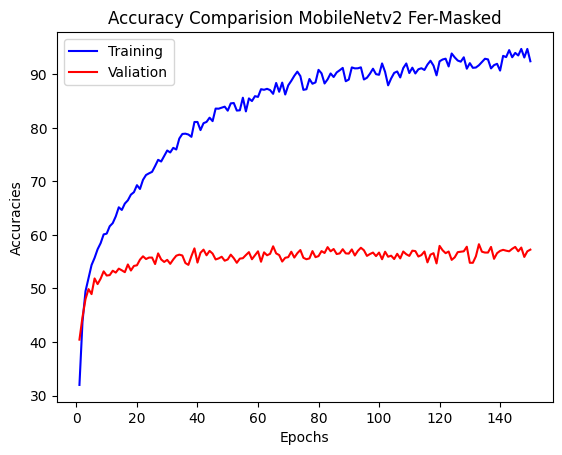

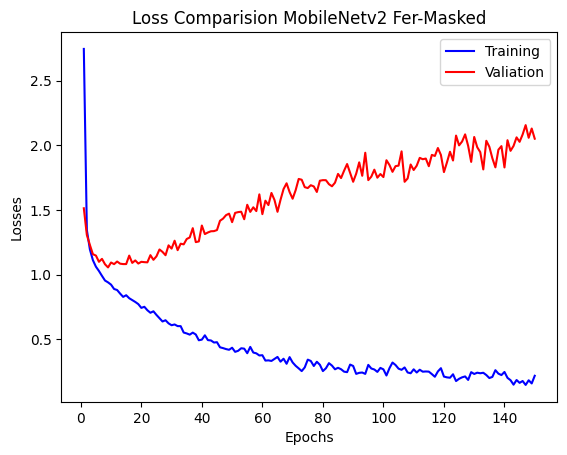

Test Accuracy of the model on the 4250 test images: 43.317647058823525 %


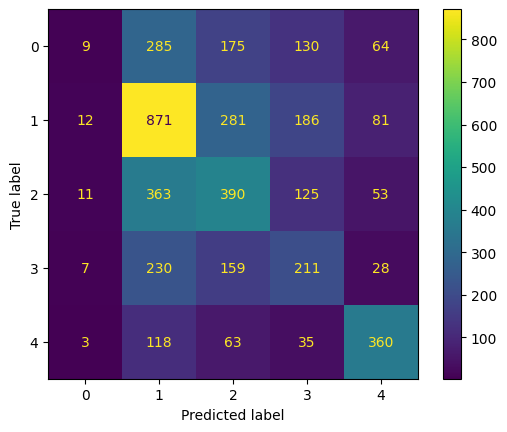

Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


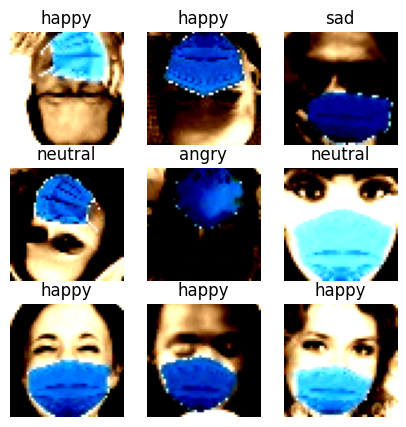

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1280, 2, 2]          --
|    └─Conv2d: 2-1                       [-1, 16, 24, 24]          432
|    └─BatchNorm2d: 2-2                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-3                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 16, 24, 24]          144
|    └─BatchNorm2d: 2-5                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-6                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-7                       [-1, 8, 24, 24]           128
|    └─BatchNorm2d: 2-8                  [-1, 8, 24, 24]           16
|    └─Sequential: 2-9                   [-1, 16, 12, 12]          --
|    |    └─_InvertedResidual: 3-1       [-1, 16, 12, 12]          920
|    |    └─_InvertedResidual: 3-2       [-1, 16, 12, 12]          2,192
|    |    └─_InvertedResidual: 3

Epoch [41/150], Training Loss: 0.7397, Validation Loss: 1.0689, Training Accuracy: 68.68%, Validation Accuracy: 56.2793,
Epoch [42/150], Training Loss: 0.7360, Validation Loss: 1.0907, Training Accuracy: 69.44%, Validation Accuracy: 55.6552,
Epoch [43/150], Training Loss: 0.7235, Validation Loss: 1.0971, Training Accuracy: 69.61%, Validation Accuracy: 56.5913,
Epoch [44/150], Training Loss: 0.7105, Validation Loss: 1.0753, Training Accuracy: 70.97%, Validation Accuracy: 55.1872,
Epoch [45/150], Training Loss: 0.7281, Validation Loss: 1.1751, Training Accuracy: 69.49%, Validation Accuracy: 54.0952,
Epoch [46/150], Training Loss: 0.7121, Validation Loss: 1.0980, Training Accuracy: 70.39%, Validation Accuracy: 56.8643,
Epoch [47/150], Training Loss: 0.7025, Validation Loss: 1.0694, Training Accuracy: 70.88%, Validation Accuracy: 56.5133,
Epoch [48/150], Training Loss: 0.6929, Validation Loss: 1.1497, Training Accuracy: 71.21%, Validation Accuracy: 56.0452,
Epoch [49/150], Training Loss: 0

Epoch [109/150], Training Loss: 0.4561, Validation Loss: 1.3724, Training Accuracy: 82.23%, Validation Accuracy: 56.7473,
Epoch [110/150], Training Loss: 0.4489, Validation Loss: 1.4026, Training Accuracy: 82.42%, Validation Accuracy: 57.3323,
Epoch [111/150], Training Loss: 0.4648, Validation Loss: 1.3082, Training Accuracy: 82.28%, Validation Accuracy: 59.2044,
Epoch [112/150], Training Loss: 0.4865, Validation Loss: 1.3946, Training Accuracy: 80.92%, Validation Accuracy: 56.4353,
Epoch [113/150], Training Loss: 0.4310, Validation Loss: 1.4228, Training Accuracy: 82.95%, Validation Accuracy: 55.1872,
Epoch [114/150], Training Loss: 0.4202, Validation Loss: 1.4362, Training Accuracy: 83.42%, Validation Accuracy: 57.0983,
Epoch [115/150], Training Loss: 0.4186, Validation Loss: 1.4439, Training Accuracy: 84.09%, Validation Accuracy: 56.5913,
Epoch [116/150], Training Loss: 0.4633, Validation Loss: 1.4132, Training Accuracy: 81.85%, Validation Accuracy: 55.8502,
Epoch [117/150], Trainin

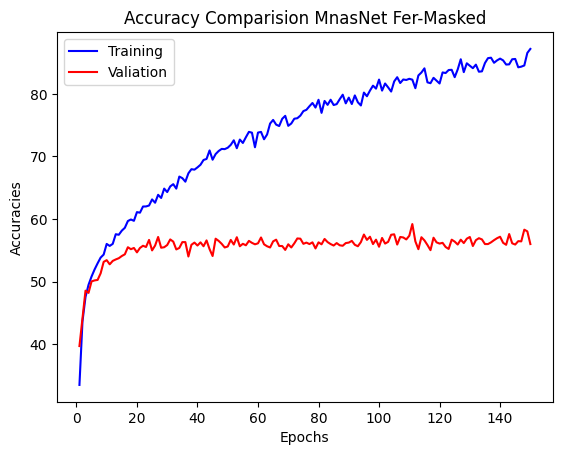

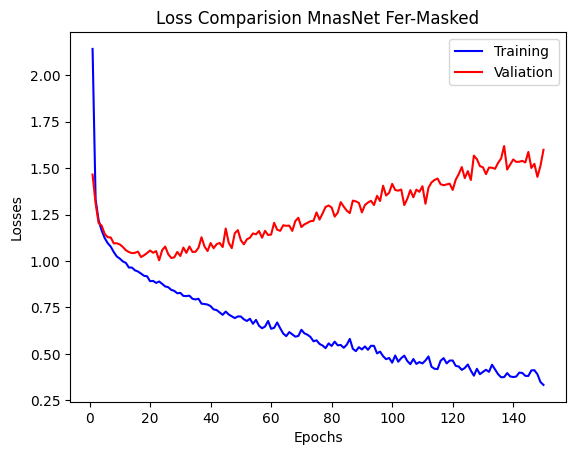

Test Accuracy of the model on the 4250 test images: 40.400000000000006 %


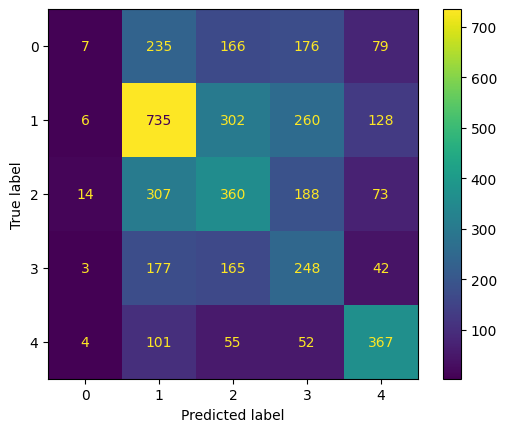

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 24403
Size Of Test Dataset 7178
Size Of Validation Dataset 4306
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


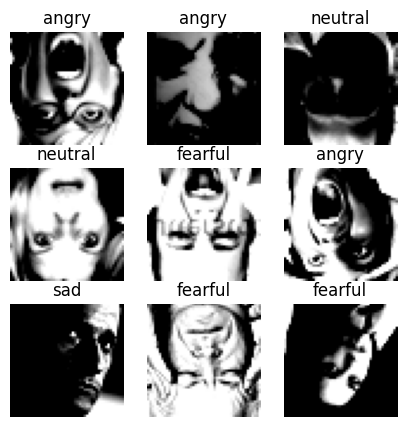

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 24, 24, 24]          648
|    └─BatchNorm2d: 2-2                  [-1, 24, 24, 24]          48
|    └─ReLU: 2-3                         [-1, 24, 24, 24]          --
├─MaxPool2d: 1-2                         [-1, 24, 12, 12]          --
├─Sequential: 1-3                        [-1, 48, 6, 6]            --
|    └─InvertedResidual: 2-4             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-1              [-1, 24, 6, 6]            888
|    |    └─Sequential: 3-2              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-5             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-3              [-1, 24, 6, 6]            1,512
|    └─InvertedResidual: 2-6             [-1, 48, 6, 6]            --
|    |    └─Sequential: 3-4    

Epoch [34/150], Training Loss: 1.2393, Validation Loss: 1.4723, Training Accuracy: 52.76%, Validation Accuracy: 43.6600,
Epoch [35/150], Training Loss: 1.2350, Validation Loss: 1.4684, Training Accuracy: 52.90%, Validation Accuracy: 43.3117,
Epoch [36/150], Training Loss: 1.2353, Validation Loss: 1.4654, Training Accuracy: 52.92%, Validation Accuracy: 44.1477,
Epoch [37/150], Training Loss: 1.2258, Validation Loss: 1.4649, Training Accuracy: 53.19%, Validation Accuracy: 44.6122,
Epoch [38/150], Training Loss: 1.2184, Validation Loss: 1.4600, Training Accuracy: 53.93%, Validation Accuracy: 44.3567,
Epoch [39/150], Training Loss: 1.2099, Validation Loss: 1.4776, Training Accuracy: 54.17%, Validation Accuracy: 44.5193,
Epoch [40/150], Training Loss: 1.1981, Validation Loss: 1.4853, Training Accuracy: 54.51%, Validation Accuracy: 43.7065,
Epoch [41/150], Training Loss: 1.1981, Validation Loss: 1.4796, Training Accuracy: 54.52%, Validation Accuracy: 44.4496,
Epoch [42/150], Training Loss: 1

Epoch [102/150], Training Loss: 0.9059, Validation Loss: 1.6384, Training Accuracy: 66.85%, Validation Accuracy: 44.8908,
Epoch [103/150], Training Loss: 0.9060, Validation Loss: 1.6527, Training Accuracy: 66.75%, Validation Accuracy: 43.4742,
Epoch [104/150], Training Loss: 0.9038, Validation Loss: 1.6322, Training Accuracy: 66.63%, Validation Accuracy: 44.1941,
Epoch [105/150], Training Loss: 0.8939, Validation Loss: 1.6551, Training Accuracy: 67.05%, Validation Accuracy: 43.8690,
Epoch [106/150], Training Loss: 0.9000, Validation Loss: 1.6515, Training Accuracy: 66.77%, Validation Accuracy: 43.7761,
Epoch [107/150], Training Loss: 0.8841, Validation Loss: 1.6522, Training Accuracy: 67.14%, Validation Accuracy: 44.9141,
Epoch [108/150], Training Loss: 0.8919, Validation Loss: 1.6565, Training Accuracy: 66.98%, Validation Accuracy: 43.6832,
Epoch [109/150], Training Loss: 0.8863, Validation Loss: 1.6454, Training Accuracy: 67.29%, Validation Accuracy: 43.9387,
Epoch [110/150], Trainin

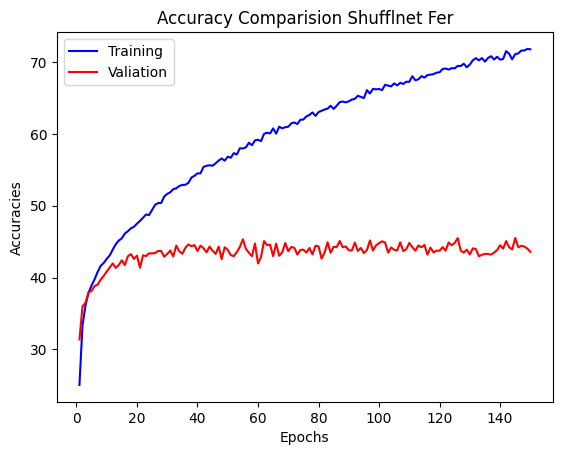

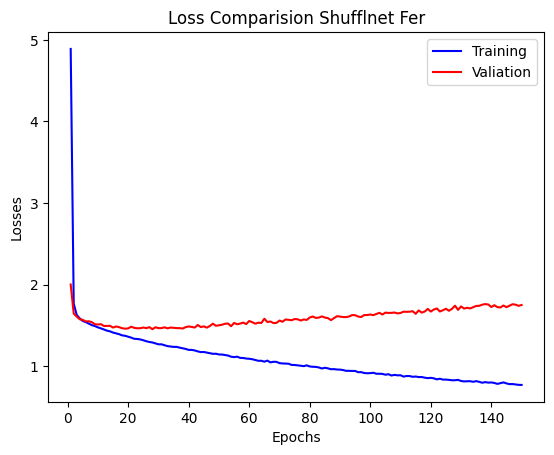

Test Accuracy of the model on the 7178 test images: 44.0651992198384 %


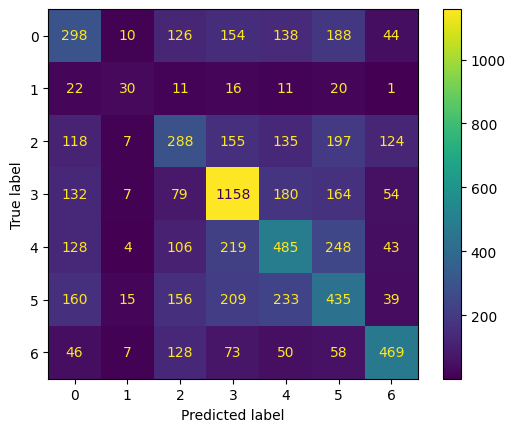

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 24403
Size Of Test Dataset 7178
Size Of Validation Dataset 4306
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


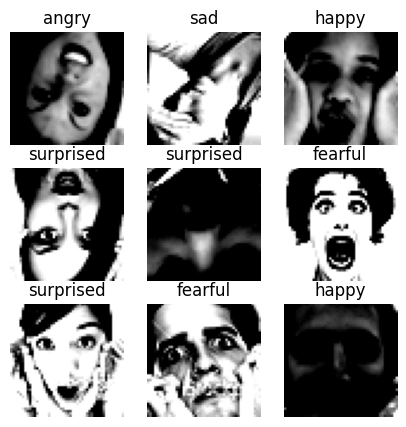

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 576, 2, 2]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 16, 24, 24]          432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 24, 24]          32
|    |    └─Hardswish: 3-3                         [-1, 16, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 12, 12]          --
|    |    └─Sequential: 3-4                        [-1, 16, 12, 12]          744
|    └─InvertedResidual: 2-3                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-5                        [-1, 24, 6, 6]            3,864
|    └─InvertedResidual: 2-4                       [-1, 24, 6, 6]            --
|    |    └─Sequential: 3-6                        [-1, 24, 6, 6

Epoch [37/150], Training Loss: 0.8757, Validation Loss: 1.9009, Training Accuracy: 68.34%, Validation Accuracy: 39.2940,
Epoch [38/150], Training Loss: 0.8526, Validation Loss: 1.9022, Training Accuracy: 69.09%, Validation Accuracy: 39.6656,
Epoch [39/150], Training Loss: 0.8472, Validation Loss: 1.9082, Training Accuracy: 69.53%, Validation Accuracy: 39.9210,
Epoch [40/150], Training Loss: 0.8286, Validation Loss: 1.9696, Training Accuracy: 69.74%, Validation Accuracy: 39.1082,
Epoch [41/150], Training Loss: 0.8076, Validation Loss: 1.9869, Training Accuracy: 70.75%, Validation Accuracy: 39.4566,
Epoch [42/150], Training Loss: 0.8093, Validation Loss: 1.9609, Training Accuracy: 71.06%, Validation Accuracy: 41.0125,
Epoch [43/150], Training Loss: 0.7929, Validation Loss: 2.0036, Training Accuracy: 71.45%, Validation Accuracy: 39.6424,
Epoch [44/150], Training Loss: 0.7808, Validation Loss: 2.0334, Training Accuracy: 71.56%, Validation Accuracy: 39.4798,
Epoch [45/150], Training Loss: 0

Epoch [105/150], Training Loss: 0.3605, Validation Loss: 2.9235, Training Accuracy: 87.30%, Validation Accuracy: 39.7120,
Epoch [106/150], Training Loss: 0.3465, Validation Loss: 2.9544, Training Accuracy: 87.68%, Validation Accuracy: 40.4784,
Epoch [107/150], Training Loss: 0.3503, Validation Loss: 2.9754, Training Accuracy: 87.62%, Validation Accuracy: 40.6874,
Epoch [108/150], Training Loss: 0.3439, Validation Loss: 2.9247, Training Accuracy: 87.78%, Validation Accuracy: 40.3391,
Epoch [109/150], Training Loss: 0.3495, Validation Loss: 2.9490, Training Accuracy: 87.58%, Validation Accuracy: 40.8035,
Epoch [110/150], Training Loss: 0.3355, Validation Loss: 2.9708, Training Accuracy: 88.25%, Validation Accuracy: 40.2462,
Epoch [111/150], Training Loss: 0.3375, Validation Loss: 3.0118, Training Accuracy: 88.09%, Validation Accuracy: 40.3855,
Epoch [112/150], Training Loss: 0.3306, Validation Loss: 3.0433, Training Accuracy: 88.34%, Validation Accuracy: 39.8978,
Epoch [113/150], Trainin

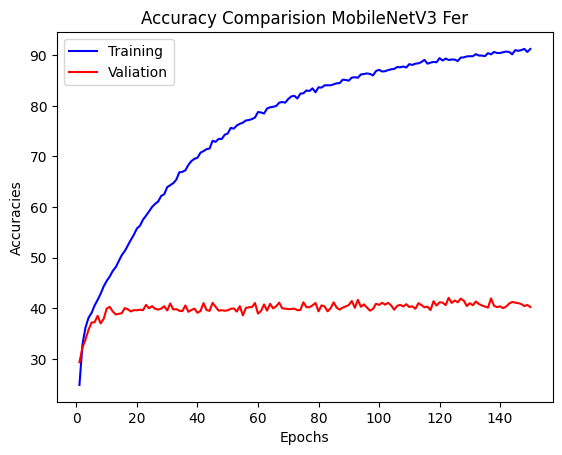

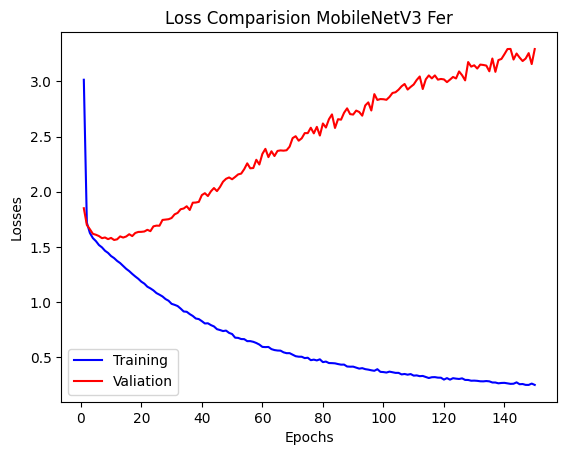

Test Accuracy of the model on the 7178 test images: 42.073000835887434 %


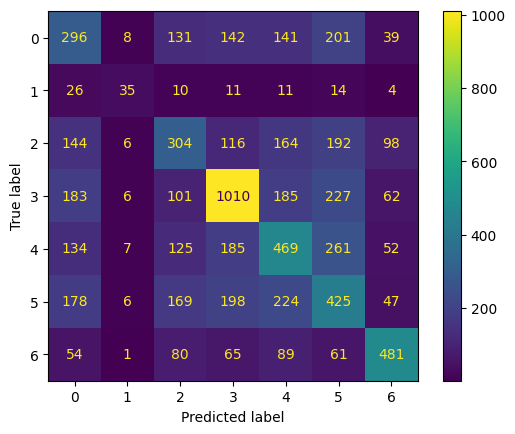

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 24403
Size Of Test Dataset 7178
Size Of Validation Dataset 4306
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


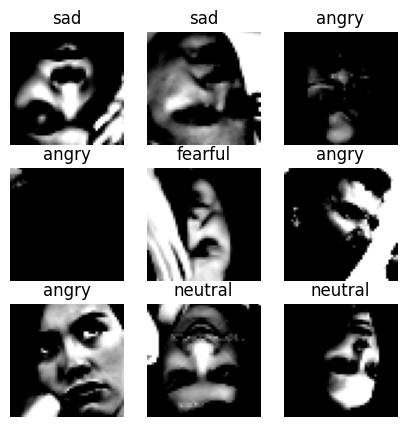

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 2, 2]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 24, 24]          --
|    |    └─Conv2d: 3-1                            [-1, 32, 24, 24]          864
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 24, 24]          64
|    |    └─ReLU6: 3-3                             [-1, 32, 24, 24]          --
|    └─InvertedResidual: 2-2                       [-1, 16, 24, 24]          --
|    |    └─Sequential: 3-4                        [-1, 16, 24, 24]          896
|    └─InvertedResidual: 2-3                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-5                        [-1, 24, 12, 12]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 12, 12]          --
|    |    └─Sequential: 3-6                        [-1, 24, 12, 

Epoch [31/150], Training Loss: 0.7511, Validation Loss: 1.8142, Training Accuracy: 73.14%, Validation Accuracy: 44.7283,
Epoch [32/150], Training Loss: 0.7275, Validation Loss: 1.7626, Training Accuracy: 73.70%, Validation Accuracy: 46.3539,
Epoch [33/150], Training Loss: 0.7040, Validation Loss: 1.9205, Training Accuracy: 74.77%, Validation Accuracy: 44.9373,
Epoch [34/150], Training Loss: 0.6854, Validation Loss: 1.8691, Training Accuracy: 75.23%, Validation Accuracy: 45.6572,
Epoch [35/150], Training Loss: 0.6640, Validation Loss: 1.8524, Training Accuracy: 76.51%, Validation Accuracy: 46.4004,
Epoch [36/150], Training Loss: 0.6491, Validation Loss: 1.8977, Training Accuracy: 76.60%, Validation Accuracy: 45.4482,
Epoch [37/150], Training Loss: 0.6340, Validation Loss: 1.9140, Training Accuracy: 77.14%, Validation Accuracy: 46.3771,
Epoch [38/150], Training Loss: 0.6203, Validation Loss: 1.9517, Training Accuracy: 77.77%, Validation Accuracy: 46.7255,
Epoch [39/150], Training Loss: 0

Epoch [99/150], Training Loss: 0.2598, Validation Loss: 2.7354, Training Accuracy: 90.93%, Validation Accuracy: 46.2610,
Epoch [100/150], Training Loss: 0.2565, Validation Loss: 2.7365, Training Accuracy: 90.89%, Validation Accuracy: 46.9577,
Epoch [101/150], Training Loss: 0.2528, Validation Loss: 2.7690, Training Accuracy: 91.03%, Validation Accuracy: 46.5397,
Epoch [102/150], Training Loss: 0.2539, Validation Loss: 2.7425, Training Accuracy: 91.07%, Validation Accuracy: 47.2596,
Epoch [103/150], Training Loss: 0.2590, Validation Loss: 2.7579, Training Accuracy: 90.69%, Validation Accuracy: 47.2829,
Epoch [104/150], Training Loss: 0.2536, Validation Loss: 2.7612, Training Accuracy: 91.08%, Validation Accuracy: 46.9345,
Epoch [105/150], Training Loss: 0.2545, Validation Loss: 2.6899, Training Accuracy: 91.07%, Validation Accuracy: 47.1667,
Epoch [106/150], Training Loss: 0.2403, Validation Loss: 2.7889, Training Accuracy: 91.68%, Validation Accuracy: 46.4004,
Epoch [107/150], Training

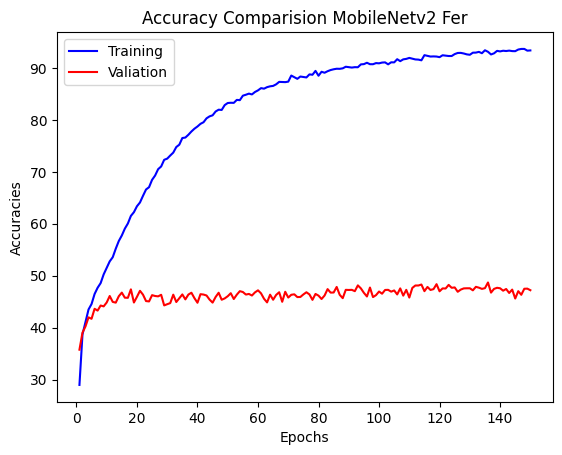

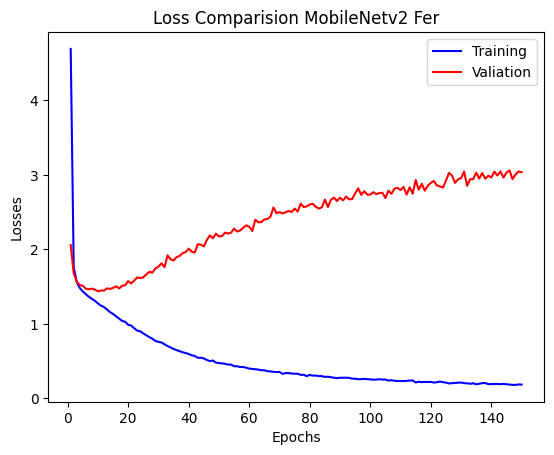

Test Accuracy of the model on the 7178 test images: 47.032599609919195 %


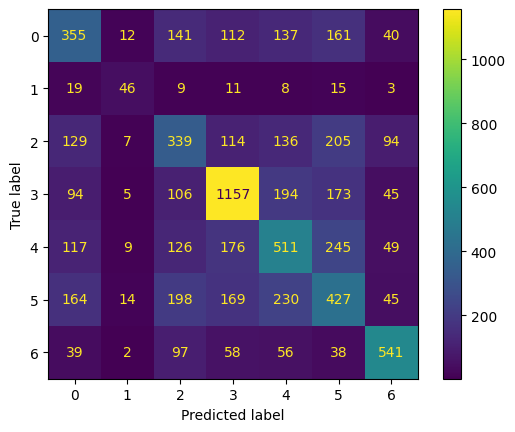

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 24403
Size Of Test Dataset 7178
Size Of Validation Dataset 4306
Images batch shape: torch.Size([64, 3, 48, 48])
Labels batch shape: torch.Size([64])
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


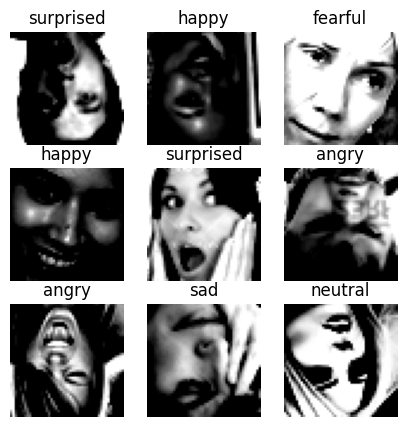

Device: cuda:0
----------PARAMETERS----------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1280, 2, 2]          --
|    └─Conv2d: 2-1                       [-1, 16, 24, 24]          432
|    └─BatchNorm2d: 2-2                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-3                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 16, 24, 24]          144
|    └─BatchNorm2d: 2-5                  [-1, 16, 24, 24]          32
|    └─ReLU: 2-6                         [-1, 16, 24, 24]          --
|    └─Conv2d: 2-7                       [-1, 8, 24, 24]           128
|    └─BatchNorm2d: 2-8                  [-1, 8, 24, 24]           16
|    └─Sequential: 2-9                   [-1, 16, 12, 12]          --
|    |    └─_InvertedResidual: 3-1       [-1, 16, 12, 12]          920
|    |    └─_InvertedResidual: 3-2       [-1, 16, 12, 12]          2,192
|    |    └─_InvertedResidual: 3

Epoch [41/150], Training Loss: 1.0730, Validation Loss: 1.6056, Training Accuracy: 59.67%, Validation Accuracy: 43.3117,
Epoch [42/150], Training Loss: 1.0680, Validation Loss: 1.6162, Training Accuracy: 59.53%, Validation Accuracy: 43.2652,
Epoch [43/150], Training Loss: 1.0608, Validation Loss: 1.5863, Training Accuracy: 60.18%, Validation Accuracy: 44.3799,
Epoch [44/150], Training Loss: 1.0503, Validation Loss: 1.6336, Training Accuracy: 60.71%, Validation Accuracy: 42.6614,
Epoch [45/150], Training Loss: 1.0337, Validation Loss: 1.6216, Training Accuracy: 61.30%, Validation Accuracy: 44.0084,
Epoch [46/150], Training Loss: 1.0314, Validation Loss: 1.6235, Training Accuracy: 61.28%, Validation Accuracy: 43.9619,
Epoch [47/150], Training Loss: 1.0192, Validation Loss: 1.6489, Training Accuracy: 61.94%, Validation Accuracy: 42.8936,
Epoch [48/150], Training Loss: 1.0127, Validation Loss: 1.6528, Training Accuracy: 61.64%, Validation Accuracy: 43.5207,
Epoch [49/150], Training Loss: 1

Epoch [109/150], Training Loss: 0.6412, Validation Loss: 2.0843, Training Accuracy: 76.67%, Validation Accuracy: 43.8458,
Epoch [110/150], Training Loss: 0.6285, Validation Loss: 2.1566, Training Accuracy: 76.90%, Validation Accuracy: 43.7529,
Epoch [111/150], Training Loss: 0.6294, Validation Loss: 2.1854, Training Accuracy: 76.96%, Validation Accuracy: 42.8936,
Epoch [112/150], Training Loss: 0.6227, Validation Loss: 2.1422, Training Accuracy: 77.04%, Validation Accuracy: 43.2420,
Epoch [113/150], Training Loss: 0.6275, Validation Loss: 2.1793, Training Accuracy: 77.11%, Validation Accuracy: 43.3349,
Epoch [114/150], Training Loss: 0.6180, Validation Loss: 2.1487, Training Accuracy: 77.29%, Validation Accuracy: 43.9619,
Epoch [115/150], Training Loss: 0.6167, Validation Loss: 2.1521, Training Accuracy: 77.43%, Validation Accuracy: 43.4046,
Epoch [116/150], Training Loss: 0.6029, Validation Loss: 2.1942, Training Accuracy: 77.93%, Validation Accuracy: 43.9619,
Epoch [117/150], Trainin

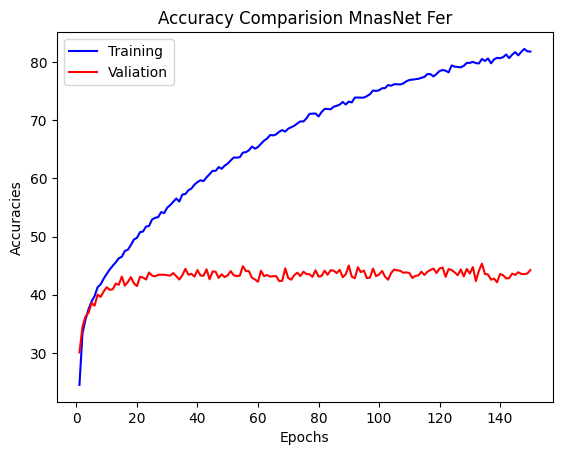

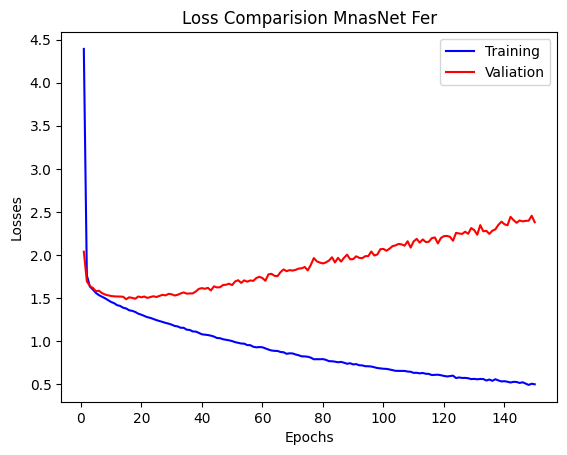

Test Accuracy of the model on the 7178 test images: 43.38255781554751 %


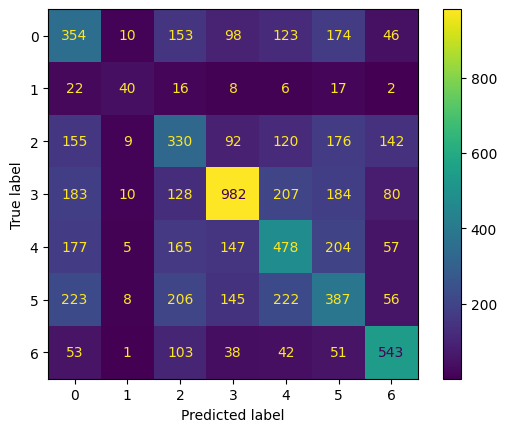

In [10]:

train_paths=['C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/Natural-Faces/train',
             'C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/tiny/train',
             'C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/Masked-fer2013/train',
             'C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/fer/train']

test_paths=['C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/Natural-Faces/test',
            'C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/tiny/test',
            'C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/Masked-fer2013/test',
            'C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/fer/test']

mdl_path='C:/Users/raqui/Documents/Datasets/Models/'
img_path='C:/Users/raqui/Documents/Datasets/Images/'  

mn=[[0.5236, 0.5236, 0.5236],[0.5422, 0.4674, 0.4349],[0.4652, 0.5198, 0.5736],[0.5074, 0.5074, 0.5074]]
sd=[[0.2351, 0.2351, 0.2351],[0.2665, 0.2500, 0.2517],[0.2354, 0.2363, 0.2666],[0.2551, 0.2551, 0.2551]]


batch_size=64
image_size=(48,48)
num_epochs=150
learning_rate=0.0001

dtaname=['Natural-Faces','Tiny','Fer-Masked','Fer']

mdls=[torchvision.models.shufflenet_v2_x0_5(),torchvision.models.mobilenet_v3_small(),torchvision.models.mobilenet_v2(),torchvision.models.mnasnet0_5()]
mdlname=['Shufflnet','MobileNetV3','MobileNetv2','MnasNet'] 


for i in range(0,len(train_paths)):
    for k in range (0,len(mdls)):
        
        train_folder=train_paths[i]
        test_folder=test_paths[i]
        train_loader,test_loader,val_loader,lablist=load_data(train_folder,test_folder,batch_size,image_size,mn[i],sd[i])
        
        # mean, std = batch_mean_and_sd(train_loader)
        # print("mean and std: \n", mean, std)
        
        img_show(train_loader,lablist)
        model=mdls[k]#model reinitialized to prevent transfer learning on the other data sets
        
        
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=5,gamma=0.5) # SCHEDULED LEARNING RATE

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Device: {}".format(device))
        model.to(device)
        
        print('----------PARAMETERS----------') #PRINTING MODEL AND NO OF PARAMTERS FOR A GIVEN INPUT SIZE
        summary(model, (3,48,48))
        # print('----------FLOPS----------')
        # count_ops(model, torch.rand(1,3,48,48).to(device))
        
        
        model,t_acc,v_acc,t_loss,v_loss,epc=train_model(num_epochs,train_loader,val_loader) # TRAINING MODEL
        
        title=mdlname[k]+' '+dtaname[i]
        grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs','Accuracies','Accuracy Comparision '+title,img_path) #DISPLAYING AND STORING GRAPHS
        grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs','Losses','Loss Comparision '+title,img_path)
    
        test_model(model,test_loader)  # TESTING MODEL
        torch.save(model, mdl_path+title) # SAVING MODEL
        torch.cuda.empty_cache() 

    
    
    
